In [1]:
# Import library
import warnings
warnings.filterwarnings('ignore')
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import time
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.models import load_model
from sklearn import metrics
import matplotlib.ticker as ticker
import scipy.stats as stats
import itertools

In [2]:
# Load WEHA stock dataset
df_weha = pd.read_excel(
    'transportation_stocks.xlsx', sheet_name='WEHA.JK')
df_weha.set_index('Date', drop=True, inplace=True)
df_weha.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-04-01,183749939.0,185624939.0,183749939.0,183749939.0,181416550.0,505066.0
2011-04-04,182812439.0,183749939.0,182812439.0,182812439.0,180490952.0,736000.0
2011-04-05,181874939.0,182812439.0,181874939.0,181874939.0,179565369.0,777066.0
2011-04-06,180937439.0,181874939.0,180937439.0,180937439.0,178639771.0,595200.0
2011-04-07,180937439.0,180937439.0,180937439.0,180937439.0,178639771.0,661333.0


In [3]:
# Check datatypes
print(df_weha.dtypes)

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object


In [4]:
# Check missing value
print(df_weha.isnull().sum())

Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64


In [5]:
# Fill missing value using mean imputation
for i in df_weha[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]:
    df_weha[i].fillna(df_weha[i].mean(), inplace=True)

print(df_weha.isnull().sum())

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


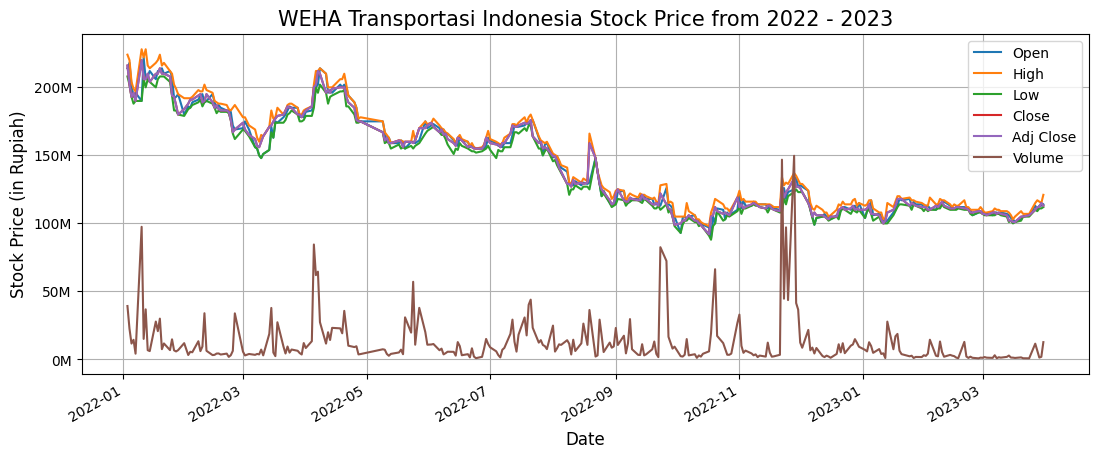

In [6]:
# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# Visualize the historical prices from 2022 - 2023
df_weha['2022':].plot(figsize=(13,5))
plt.title('WEHA Transportasi Indonesia Stock Price from 2022 - 2023', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Stock Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

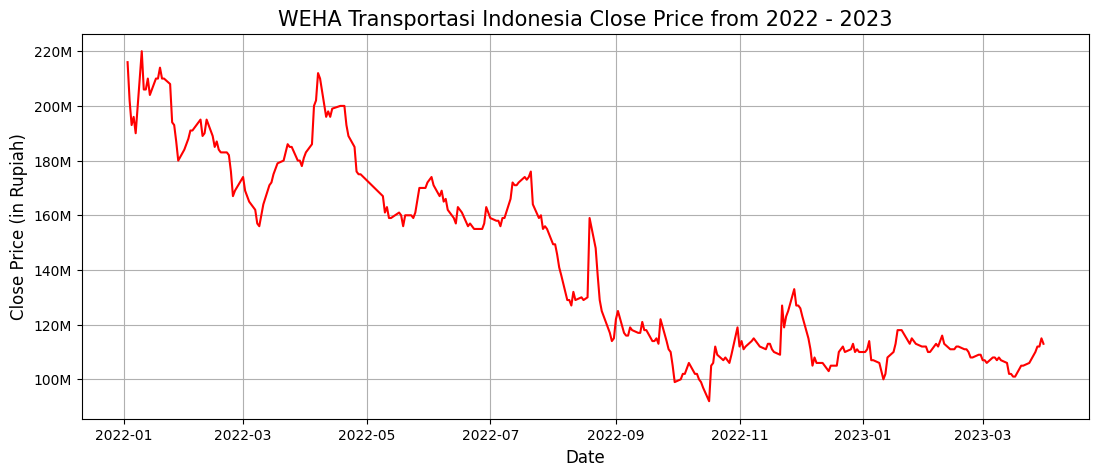

In [7]:
# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# Visualize each of price attributes
plt.figure(figsize=(13,5))
plt.plot(df_weha['Close']['2022':], color='red')
plt.title('WEHA Transportasi Indonesia Close Price from 2022 - 2023', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

In [8]:
# Select the close price column as the target variable
target_col = 'Close'

# Create a new dataframe with only the target variable
target_df = pd.DataFrame(df_weha[target_col])

# Split the data into training and testing sets
train_size = int(len(target_df) * 0.9)
train_df = target_df[:train_size]
test_df = target_df[train_size:]
print('Training Set: ', train_df.shape)
print('Testing Set: ', test_df.shape)

Training Set:  (2682, 1)
Testing Set:  (298, 1)


In [9]:
# Scale the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_df)
test_scaled = scaler.transform(test_df)
print('Training Scaled: ', train_scaled[0:5], '\n')
print('Testing Scaled: ', test_scaled[0:5])

Training Scaled:  [[0.52450956]
 [0.52083309]
 [0.51715662]
 [0.51348015]
 [0.51348015]] 

Testing Scaled:  [[0.62745098]
 [0.62745098]
 [0.64313725]
 [0.62745098]
 [0.62745098]]


In [10]:
# Define the sequence length and number of features
sequence_length = 60
num_features = 1

# Define the function to create sequences
def create_sequences(X, y, seq_length):
    X_sequences, y_sequences = [], []
    for i in range(seq_length, len(X)):
        X_sequences.append(X[i-seq_length:i, :])
        y_sequences.append(y[i, :])
    return np.array(X_sequences), np.array(y_sequences)

# Create training sequences and labels
X_train, y_train = create_sequences(train_scaled, train_scaled, sequence_length)

# Create testing sequences and labels
X_test, y_test = create_sequences(test_scaled, test_scaled, sequence_length)

# Print the shape of the training and testing sets
print('X train shape:', X_train.shape)
print('y train shape:', y_train.shape)
print('X test shape:', X_test.shape)
print('y test shape:', y_test.shape)

X train shape: (2622, 60, 1)
y train shape: (2622, 1)
X test shape: (238, 60, 1)
y test shape: (238, 1)


##### LSTM Network Default Model

In [11]:
# define the model
model = Sequential()
model.add(LSTM(32, input_shape=(sequence_length, num_features)))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error')
# train the model
model.fit(X_train, y_train, epochs=10, 
          batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 5s 72ms/step - loss: 0.0402 - val_loss: 0.0099
Epoch 2/10
24/24 [==============================] - 1s 31ms/step - loss: 0.0026 - val_loss: 0.0091
Epoch 3/10
24/24 [==============================] - 1s 29ms/step - loss: 0.0024 - val_loss: 0.0079
Epoch 4/10
24/24 [==============================] - 1s 27ms/step - loss: 0.0017 - val_loss: 0.0096
Epoch 5/10
24/24 [==============================] - 1s 26ms/step - loss: 0.0020 - val_loss: 0.0072
Epoch 6/10
24/24 [==============================] - 1s 28ms/step - loss: 0.0016 - val_loss: 0.0076
Epoch 7/10
24/24 [==============================] - 1s 27ms/step - loss: 0.0014 - val_loss: 0.0073
Epoch 8/10
24/24 [==============================] - 1s 26ms/step - loss: 0.0014 - val_loss: 0.0058
Epoch 9/10
24/24 [==============================] - 1s 27ms/step - loss: 0.0011 - val_loss: 0.0056
Epoch 10/10
24/24 [==============================] - 1s 25ms/step - loss: 0.0011 - val_loss: 0.0054
Model: "s

In [12]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 1s 6ms/step
Mean Absolute Percentage Error (MAPE):  0.08319
Mean Absolute Error (MAE):  0.0252425
Mean Squared Error (MSE):  0.0010968
Root Mean Squared Error (RMSE):  0.03312
R-Squared:  0.895916


8/8 [==============================] - 0s 7ms/step


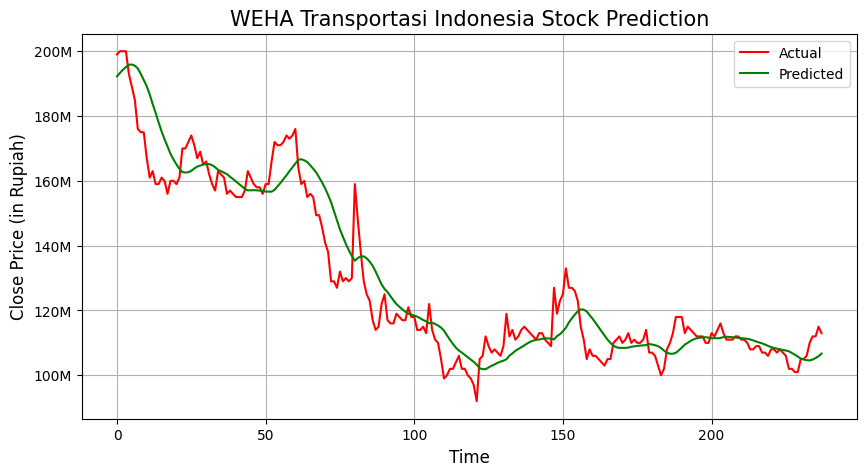

In [13]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('WEHA Transportasi Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

# Save the default model
model.save('models/weha_lstm_default.h5')

##### Linear - Adam

In [14]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 13s 248ms/step - loss: 0.0369 - val_loss: 0.0101
Epoch 2/10
24/24 [==============================] - 7s 278ms/step - loss: 0.0053 - val_loss: 0.0067
Epoch 3/10
24/24 [==============================] - 7s 288ms/step - loss: 0.0029 - val_loss: 0.0058
Epoch 4/10
24/24 [==============================] - 7s 273ms/step - loss: 0.0024 - val_loss: 0.0057
Epoch 5/10
24/24 [==============================] - 7s 274ms/step - loss: 0.0022 - val_loss: 0.0055
Epoch 6/10
24/24 [==============================] - 6s 271ms/step - loss: 0.0021 - val_loss: 0.0055
Epoch 7/10
24/24 [==============================] - 6s 270ms/step - loss: 0.0020 - val_loss: 0.0055
Epoch 8/10
24/24 [==============================] - 7s 286ms/step - loss: 0.0019 - val_loss: 0.0055
Epoch 9/10
24/24 [==============================] - 7s 272ms/step - loss: 0.0018 - val_loss: 0.0052
Epoch 10/10
24/24 [==============================] - 7s 272ms/step - loss: 0.0018 - val_loss: 0.005

In [15]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 28ms/step
Mean Absolute Percentage Error (MAPE):  0.08321
Mean Absolute Error (MAE):  0.0252313
Mean Squared Error (MSE):  0.0010934
Root Mean Squared Error (RMSE):  0.03307
R-Squared:  0.89624


8/8 [==============================] - 0s 28ms/step


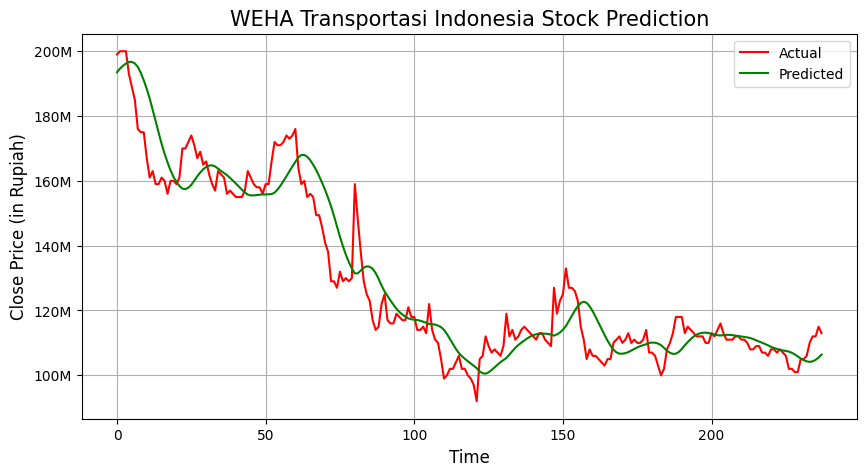

In [16]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('WEHA Transportasi Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

# Save the default model
model.save('models/weha_linear_adam.h5')

##### Linear - AdaGrad

In [17]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adagrad')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 11s 248ms/step - loss: 0.1544 - val_loss: 0.0583
Epoch 2/10
24/24 [==============================] - 10s 415ms/step - loss: 0.0497 - val_loss: 0.0412
Epoch 3/10
24/24 [==============================] - 12s 496ms/step - loss: 0.0259 - val_loss: 0.0397
Epoch 4/10
24/24 [==============================] - 14s 573ms/step - loss: 0.0205 - val_loss: 0.0394
Epoch 5/10
24/24 [==============================] - 13s 524ms/step - loss: 0.0192 - val_loss: 0.0383
Epoch 6/10
24/24 [==============================] - 12s 511ms/step - loss: 0.0184 - val_loss: 0.0369
Epoch 7/10
24/24 [==============================] - 12s 507ms/step - loss: 0.0167 - val_loss: 0.0351
Epoch 8/10
24/24 [==============================] - 12s 503ms/step - loss: 0.0164 - val_loss: 0.0334
Epoch 9/10
24/24 [==============================] - 15s 619ms/step - loss: 0.0149 - val_loss: 0.0317
Epoch 10/10
24/24 [==============================] - 12s 517ms/step - loss: 0.0146 - val_lo

In [18]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 40ms/step
Mean Absolute Percentage Error (MAPE):  0.43886
Mean Absolute Error (MAE):  0.1109192
Mean Squared Error (MSE):  0.0146597
Root Mean Squared Error (RMSE):  0.12108
R-Squared:  -0.391192


8/8 [==============================] - 0s 38ms/step


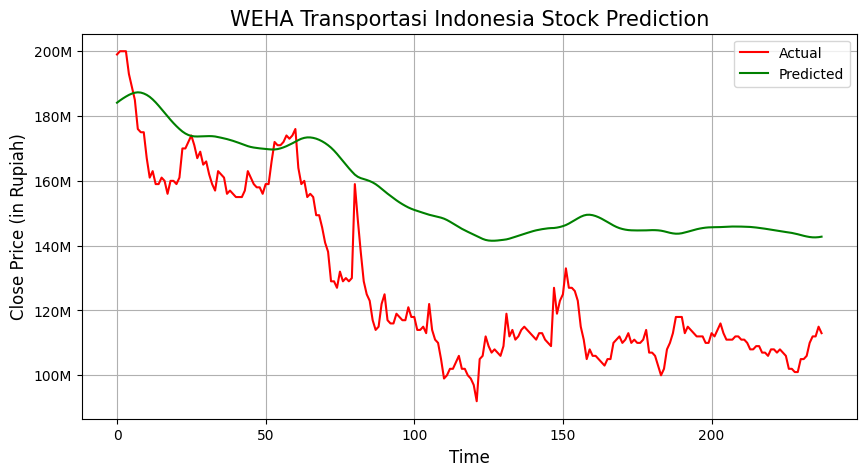

In [19]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('WEHA Transportasi Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/weha_linear_adagrad.h5')

##### Linear - Nadam

In [20]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 15s 323ms/step - loss: 0.0356 - val_loss: 0.0075
Epoch 2/10
24/24 [==============================] - 6s 267ms/step - loss: 0.0030 - val_loss: 0.0062
Epoch 3/10
24/24 [==============================] - 6s 271ms/step - loss: 0.0023 - val_loss: 0.0059
Epoch 4/10
24/24 [==============================] - 7s 272ms/step - loss: 0.0022 - val_loss: 0.0057
Epoch 5/10
24/24 [==============================] - 7s 281ms/step - loss: 0.0021 - val_loss: 0.0055
Epoch 6/10
24/24 [==============================] - 7s 299ms/step - loss: 0.0018 - val_loss: 0.0057
Epoch 7/10
24/24 [==============================] - 7s 280ms/step - loss: 0.0018 - val_loss: 0.0053
Epoch 8/10
24/24 [==============================] - 7s 277ms/step - loss: 0.0018 - val_loss: 0.0051
Epoch 9/10
24/24 [==============================] - 7s 287ms/step - loss: 0.0017 - val_loss: 0.0053
Epoch 10/10
24/24 [==============================] - 7s 294ms/step - loss: 0.0015 - val_loss: 0.005

In [21]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 33ms/step
Mean Absolute Percentage Error (MAPE):  0.086
Mean Absolute Error (MAE):  0.0259968
Mean Squared Error (MSE):  0.0011689
Root Mean Squared Error (RMSE):  0.03419
R-Squared:  0.889074


8/8 [==============================] - 0s 35ms/step


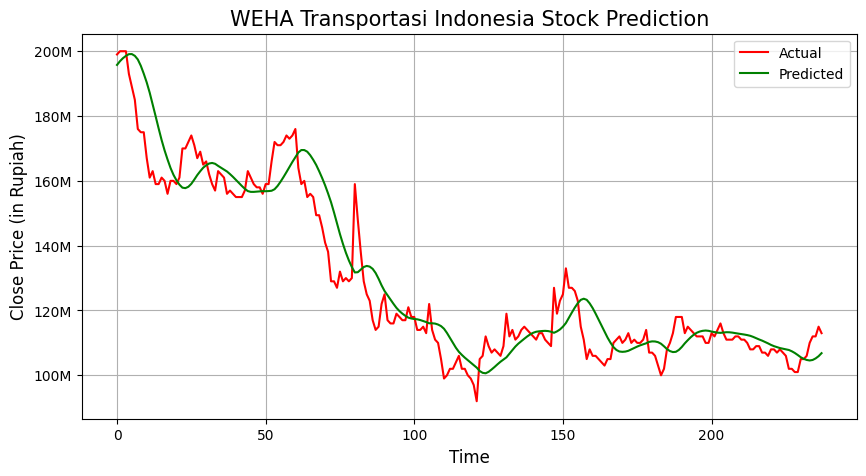

In [22]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('WEHA Transportasi Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/weha_linear_nadam.h5')

#### Linear - RMSProp

In [23]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 18s 490ms/step - loss: 0.0302 - val_loss: 0.0079
Epoch 2/10
24/24 [==============================] - 10s 413ms/step - loss: 0.0083 - val_loss: 0.0077
Epoch 3/10
24/24 [==============================] - 11s 450ms/step - loss: 0.0064 - val_loss: 0.0073
Epoch 4/10
24/24 [==============================] - 12s 486ms/step - loss: 0.0061 - val_loss: 0.0111
Epoch 5/10
24/24 [==============================] - 11s 452ms/step - loss: 0.0045 - val_loss: 0.0090
Epoch 6/10
24/24 [==============================] - 11s 442ms/step - loss: 0.0050 - val_loss: 0.0092
Epoch 7/10
24/24 [==============================] - 10s 432ms/step - loss: 0.0045 - val_loss: 0.0053
Epoch 8/10
24/24 [==============================] - 11s 466ms/step - loss: 0.0038 - val_loss: 0.0062
Epoch 9/10
24/24 [==============================] - 11s 442ms/step - loss: 0.0029 - val_loss: 0.0063
Epoch 10/10
24/24 [==============================] - 13s 531ms/step - loss: 0.0039 - val_lo

In [24]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 47ms/step
Mean Absolute Percentage Error (MAPE):  0.1155
Mean Absolute Error (MAE):  0.0336276
Mean Squared Error (MSE):  0.0017702
Root Mean Squared Error (RMSE):  0.04207
R-Squared:  0.832007


8/8 [==============================] - 0s 46ms/step


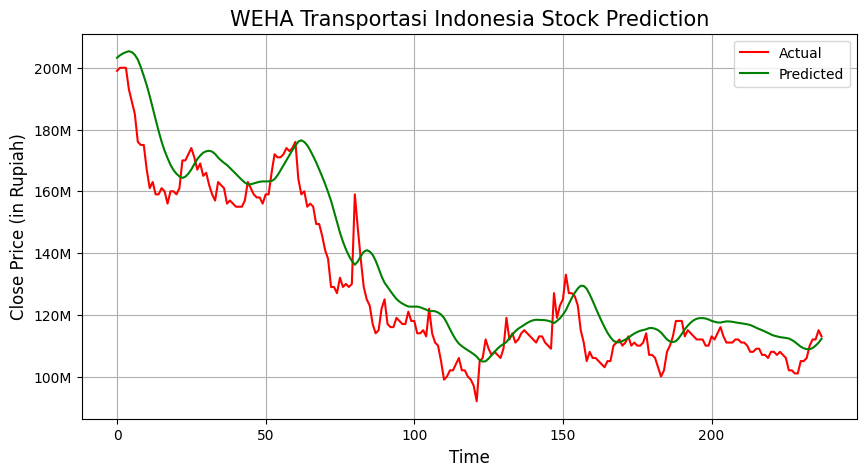

In [25]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('WEHA Transportasi Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/weha_linear_rmsprop.h5')

##### Linear - AdaDelta

In [26]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 32s 952ms/step - loss: 0.3333 - val_loss: 0.2053
Epoch 2/10
24/24 [==============================] - 9s 378ms/step - loss: 0.3248 - val_loss: 0.2014
Epoch 3/10
24/24 [==============================] - 7s 300ms/step - loss: 0.3189 - val_loss: 0.1974
Epoch 4/10
24/24 [==============================] - 7s 295ms/step - loss: 0.3113 - val_loss: 0.1935
Epoch 5/10
24/24 [==============================] - 7s 298ms/step - loss: 0.3050 - val_loss: 0.1895
Epoch 6/10
24/24 [==============================] - 7s 289ms/step - loss: 0.2992 - val_loss: 0.1855
Epoch 7/10
24/24 [==============================] - 7s 289ms/step - loss: 0.2918 - val_loss: 0.1816
Epoch 8/10
24/24 [==============================] - 7s 311ms/step - loss: 0.2862 - val_loss: 0.1776
Epoch 9/10
24/24 [==============================] - 7s 289ms/step - loss: 0.2789 - val_loss: 0.1737
Epoch 10/10
24/24 [==============================] - 7s 311ms/step - loss: 0.2716 - val_loss: 0.169

In [27]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 36ms/step
Mean Absolute Percentage Error (MAPE):  0.95377
Mean Absolute Error (MAE):  0.295402
Mean Squared Error (MSE):  0.0978937
Root Mean Squared Error (RMSE):  0.31288
R-Squared:  -8.290026


8/8 [==============================] - 0s 35ms/step


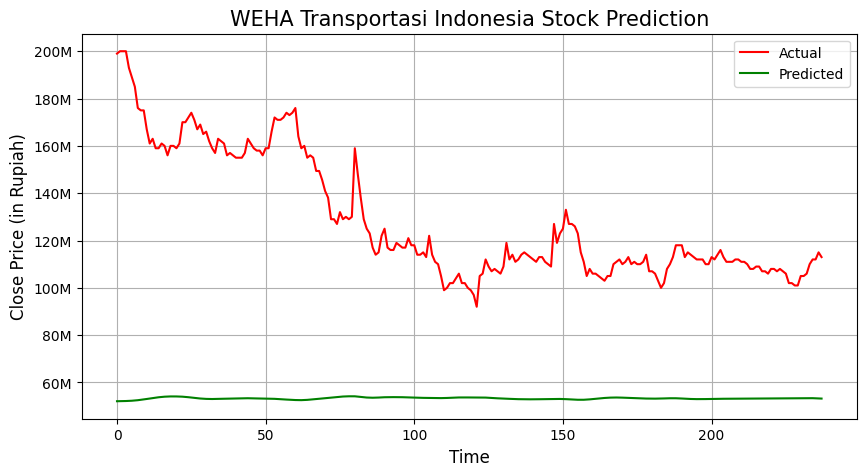

In [28]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('WEHA Transportasi Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/weha_linear_adadelta.h5')

##### Linear - SGD

In [29]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 15s 366ms/step - loss: 0.0391 - val_loss: 0.0355
Epoch 2/10
24/24 [==============================] - 5s 223ms/step - loss: 0.0162 - val_loss: 0.0265
Epoch 3/10
24/24 [==============================] - 5s 227ms/step - loss: 0.0115 - val_loss: 0.0198
Epoch 4/10
24/24 [==============================] - 6s 232ms/step - loss: 0.0096 - val_loss: 0.0147
Epoch 5/10
24/24 [==============================] - 6s 231ms/step - loss: 0.0075 - val_loss: 0.0118
Epoch 6/10
24/24 [==============================] - 6s 232ms/step - loss: 0.0064 - val_loss: 0.0099
Epoch 7/10
24/24 [==============================] - 6s 238ms/step - loss: 0.0052 - val_loss: 0.0090
Epoch 8/10
24/24 [==============================] - 6s 232ms/step - loss: 0.0045 - val_loss: 0.0086
Epoch 9/10
24/24 [==============================] - 6s 257ms/step - loss: 0.0040 - val_loss: 0.0087
Epoch 10/10
24/24 [==============================] - 6s 246ms/step - loss: 0.0035 - val_loss: 0.008

In [30]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 31ms/step
Mean Absolute Percentage Error (MAPE):  0.11867
Mean Absolute Error (MAE):  0.034591
Mean Squared Error (MSE):  0.00198
Root Mean Squared Error (RMSE):  0.0445
R-Squared:  0.812097


8/8 [==============================] - 0s 34ms/step


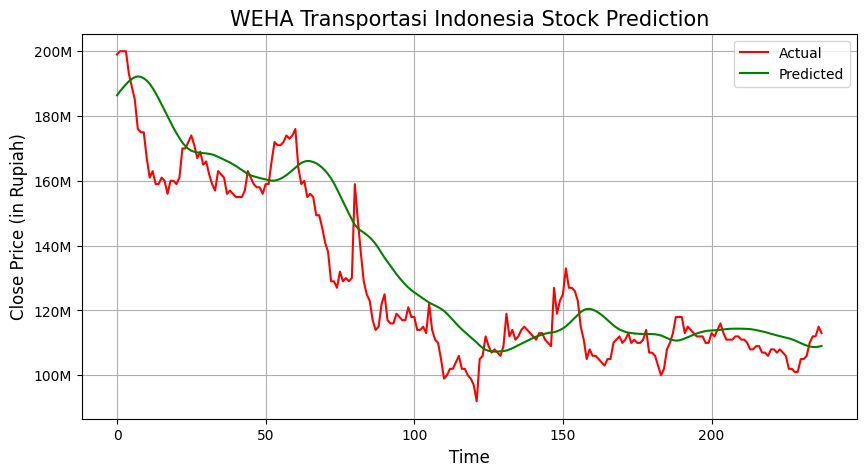

In [31]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('WEHA Transportasi Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/weha_linear_sgd.h5')

#### Linear - Adamax

In [32]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 20s 557ms/step - loss: 0.0341 - val_loss: 0.0089
Epoch 2/10
24/24 [==============================] - 12s 519ms/step - loss: 0.0047 - val_loss: 0.0075
Epoch 3/10
24/24 [==============================] - 12s 522ms/step - loss: 0.0036 - val_loss: 0.0066
Epoch 4/10
24/24 [==============================] - 14s 566ms/step - loss: 0.0029 - val_loss: 0.0062
Epoch 5/10
24/24 [==============================] - 13s 532ms/step - loss: 0.0028 - val_loss: 0.0061
Epoch 6/10
24/24 [==============================] - 13s 527ms/step - loss: 0.0027 - val_loss: 0.0061
Epoch 7/10
24/24 [==============================] - 13s 533ms/step - loss: 0.0026 - val_loss: 0.0060
Epoch 8/10
24/24 [==============================] - 13s 547ms/step - loss: 0.0025 - val_loss: 0.0061
Epoch 9/10
24/24 [==============================] - 14s 574ms/step - loss: 0.0024 - val_loss: 0.0059
Epoch 10/10
24/24 [==============================] - 13s 560ms/step - loss: 0.0023 - val_lo

In [33]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 43ms/step
Mean Absolute Percentage Error (MAPE):  0.09342
Mean Absolute Error (MAE):  0.0279091
Mean Squared Error (MSE):  0.0013162
Root Mean Squared Error (RMSE):  0.03628
R-Squared:  0.875096


8/8 [==============================] - 0s 43ms/step


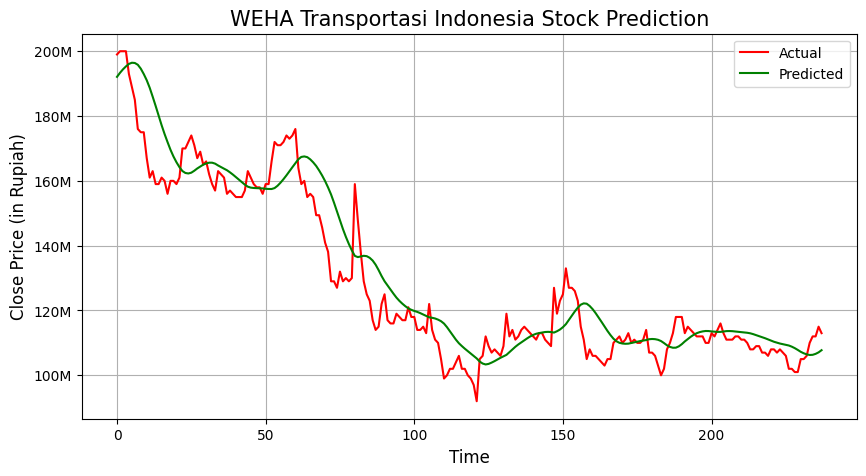

In [34]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('WEHA Transportasi Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/weha_linear_adamax.h5')

##### ReLU - Adam

In [35]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 22s 626ms/step - loss: 0.0280 - val_loss: 0.0092
Epoch 2/10
24/24 [==============================] - 11s 444ms/step - loss: 0.0038 - val_loss: 0.0064
Epoch 3/10
24/24 [==============================] - 11s 474ms/step - loss: 0.0024 - val_loss: 0.0065
Epoch 4/10
24/24 [==============================] - 12s 522ms/step - loss: 0.0023 - val_loss: 0.0063
Epoch 5/10
24/24 [==============================] - 12s 509ms/step - loss: 0.0020 - val_loss: 0.0063
Epoch 6/10
24/24 [==============================] - 12s 511ms/step - loss: 0.0018 - val_loss: 0.0064
Epoch 7/10
24/24 [==============================] - 13s 522ms/step - loss: 0.0018 - val_loss: 0.0062
Epoch 8/10
24/24 [==============================] - 12s 519ms/step - loss: 0.0016 - val_loss: 0.0068
Epoch 9/10
24/24 [==============================] - 13s 522ms/step - loss: 0.0015 - val_loss: 0.0072
Epoch 10/10
24/24 [==============================] - 12s 519ms/step - loss: 0.0014 - val_lo

In [36]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 44ms/step
Mean Absolute Percentage Error (MAPE):  0.08042
Mean Absolute Error (MAE):  0.024915
Mean Squared Error (MSE):  0.0010607
Root Mean Squared Error (RMSE):  0.03257
R-Squared:  0.899338


8/8 [==============================] - 0s 44ms/step


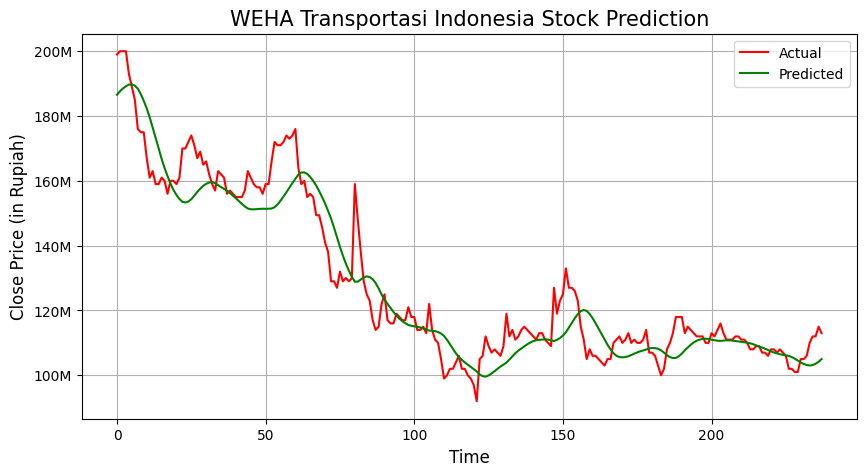

In [37]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('WEHA Transportasi Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/weha_relu_adam.h5')

#### ReLU - AdaGrad

In [38]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adagrad')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 22s 641ms/step - loss: 0.2238 - val_loss: 0.1123
Epoch 2/10
24/24 [==============================] - 15s 625ms/step - loss: 0.1563 - val_loss: 0.0843
Epoch 3/10
24/24 [==============================] - 15s 635ms/step - loss: 0.1152 - val_loss: 0.0660
Epoch 4/10
24/24 [==============================] - 15s 607ms/step - loss: 0.0869 - val_loss: 0.0540
Epoch 5/10
24/24 [==============================] - 15s 620ms/step - loss: 0.0641 - val_loss: 0.0464
Epoch 6/10
24/24 [==============================] - 16s 672ms/step - loss: 0.0498 - val_loss: 0.0423
Epoch 7/10
24/24 [==============================] - 16s 681ms/step - loss: 0.0385 - val_loss: 0.0404
Epoch 8/10
24/24 [==============================] - 16s 677ms/step - loss: 0.0322 - val_loss: 0.0399
Epoch 9/10
24/24 [==============================] - 14s 596ms/step - loss: 0.0275 - val_loss: 0.0402
Epoch 10/10
24/24 [==============================] - 14s 575ms/step - loss: 0.0251 - val_lo

In [39]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 43ms/step
Mean Absolute Percentage Error (MAPE):  0.4348
Mean Absolute Error (MAE):  0.107804
Mean Squared Error (MSE):  0.0145742
Root Mean Squared Error (RMSE):  0.12072
R-Squared:  -0.383075


8/8 [==============================] - 0s 54ms/step


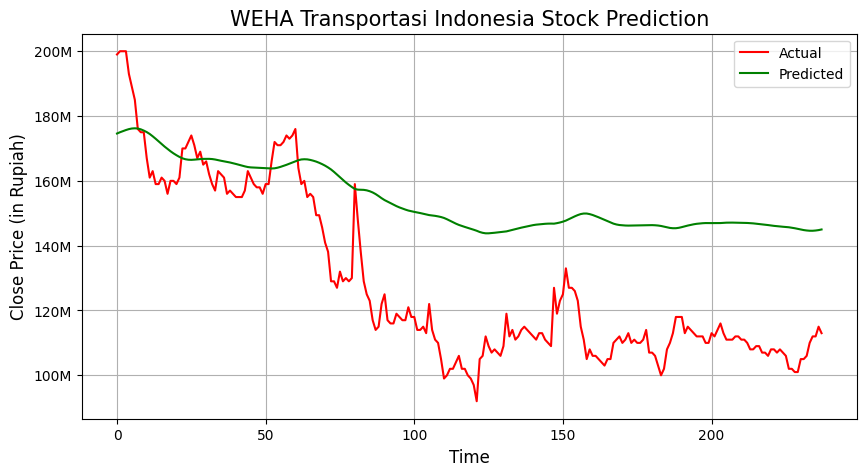

In [40]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('WEHA Transportasi Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/weha_relu_adagrad.h5')

##### ReLU - Nadam

In [41]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 18s 427ms/step - loss: 0.0582 - val_loss: 0.0091
Epoch 2/10
24/24 [==============================] - 8s 344ms/step - loss: 0.0036 - val_loss: 0.0078
Epoch 3/10
24/24 [==============================] - 8s 348ms/step - loss: 0.0029 - val_loss: 0.0078
Epoch 4/10
24/24 [==============================] - 8s 354ms/step - loss: 0.0026 - val_loss: 0.0073
Epoch 5/10
24/24 [==============================] - 8s 353ms/step - loss: 0.0024 - val_loss: 0.0071
Epoch 6/10
24/24 [==============================] - 8s 354ms/step - loss: 0.0024 - val_loss: 0.0067
Epoch 7/10
24/24 [==============================] - 9s 379ms/step - loss: 0.0023 - val_loss: 0.0066
Epoch 8/10
24/24 [==============================] - 9s 364ms/step - loss: 0.0021 - val_loss: 0.0067
Epoch 9/10
24/24 [==============================] - 9s 356ms/step - loss: 0.0019 - val_loss: 0.0065
Epoch 10/10
24/24 [==============================] - 8s 353ms/step - loss: 0.0020 - val_loss: 0.006

In [42]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 36ms/step
Mean Absolute Percentage Error (MAPE):  0.09339
Mean Absolute Error (MAE):  0.0285701
Mean Squared Error (MSE):  0.0014256
Root Mean Squared Error (RMSE):  0.03776
R-Squared:  0.864713


8/8 [==============================] - 0s 34ms/step


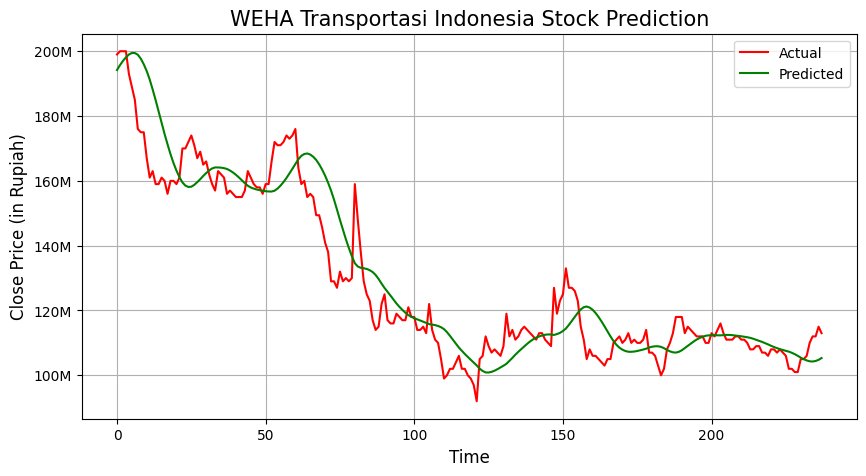

In [43]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('WEHA Transportasi Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/weha_relu_nadam.h5')

##### ReLU - RMSProp

In [44]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 14s 323ms/step - loss: 0.0269 - val_loss: 0.0108
Epoch 2/10
24/24 [==============================] - 10s 418ms/step - loss: 0.0088 - val_loss: 0.0070
Epoch 3/10
24/24 [==============================] - 11s 447ms/step - loss: 0.0073 - val_loss: 0.0127
Epoch 4/10
24/24 [==============================] - 10s 422ms/step - loss: 0.0066 - val_loss: 0.0058
Epoch 5/10
24/24 [==============================] - 10s 423ms/step - loss: 0.0049 - val_loss: 0.0090
Epoch 6/10
24/24 [==============================] - 10s 437ms/step - loss: 0.0050 - val_loss: 0.0110
Epoch 7/10
24/24 [==============================] - 12s 510ms/step - loss: 0.0051 - val_loss: 0.0060
Epoch 8/10
24/24 [==============================] - 12s 515ms/step - loss: 0.0043 - val_loss: 0.0095
Epoch 9/10
24/24 [==============================] - 13s 549ms/step - loss: 0.0041 - val_loss: 0.0072
Epoch 10/10
24/24 [==============================] - 14s 588ms/step - loss: 0.0040 - val_lo

In [45]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 88ms/step
Mean Absolute Percentage Error (MAPE):  0.12638
Mean Absolute Error (MAE):  0.0368724
Mean Squared Error (MSE):  0.0021517
Root Mean Squared Error (RMSE):  0.04639
R-Squared:  0.795802


8/8 [==============================] - 0s 49ms/step


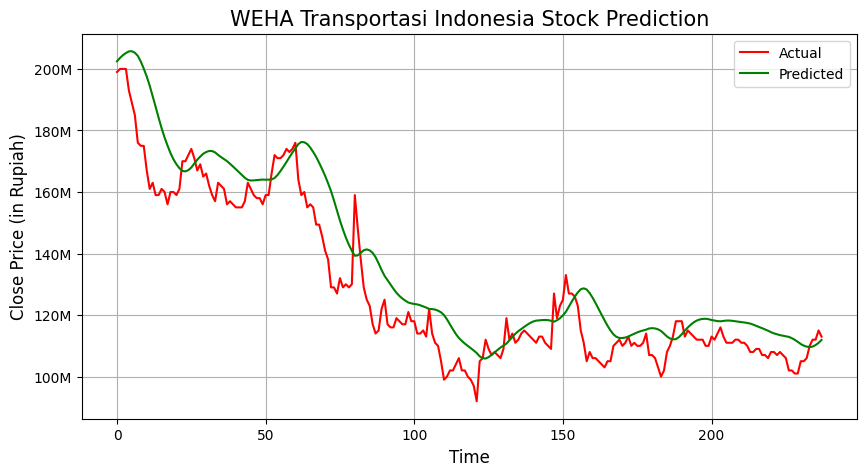

In [46]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('WEHA Transportasi Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/weha_relu_rmsprop.h5')

##### ReLU - AdaDelta

In [47]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 30s 664ms/step - loss: 0.3131 - val_loss: 0.1924
Epoch 2/10
24/24 [==============================] - 24s 1s/step - loss: 0.3094 - val_loss: 0.1903
Epoch 3/10
24/24 [==============================] - 25s 1s/step - loss: 0.3066 - val_loss: 0.1881
Epoch 4/10
24/24 [==============================] - 18s 735ms/step - loss: 0.3032 - val_loss: 0.1860
Epoch 5/10
24/24 [==============================] - 17s 723ms/step - loss: 0.2996 - val_loss: 0.1839
Epoch 6/10
24/24 [==============================] - 15s 632ms/step - loss: 0.2974 - val_loss: 0.1819
Epoch 7/10
24/24 [==============================] - 15s 632ms/step - loss: 0.2946 - val_loss: 0.1799
Epoch 8/10
24/24 [==============================] - 14s 583ms/step - loss: 0.2920 - val_loss: 0.1781
Epoch 9/10
24/24 [==============================] - 15s 620ms/step - loss: 0.2895 - val_loss: 0.1763
Epoch 10/10
24/24 [==============================] - 14s 593ms/step - loss: 0.2866 - val_loss: 0.

In [48]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 44ms/step
Mean Absolute Percentage Error (MAPE):  0.98285
Mean Absolute Error (MAE):  0.3036806
Mean Squared Error (MSE):  0.1029284
Root Mean Squared Error (RMSE):  0.32082
R-Squared:  -8.767813


8/8 [==============================] - 0s 46ms/step


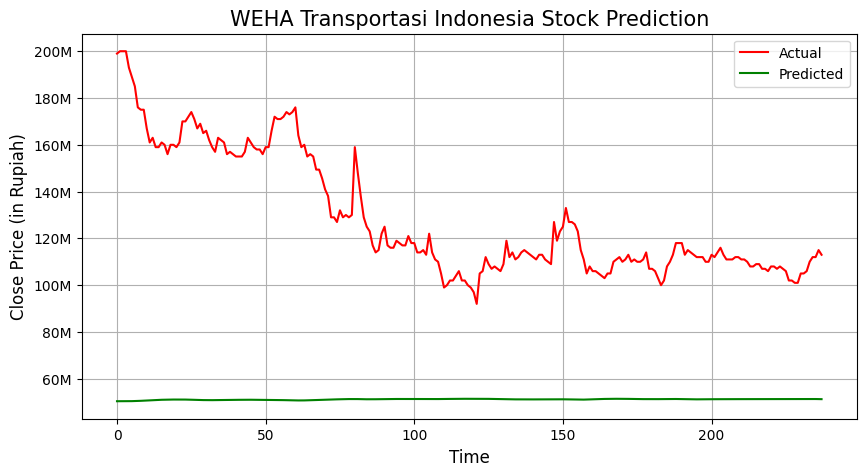

In [49]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('WEHA Transportasi Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/weha_relu_adadelta.h5')

##### ReLU - SGD

In [50]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 19s 541ms/step - loss: 0.0949 - val_loss: 0.0488
Epoch 2/10
24/24 [==============================] - 15s 617ms/step - loss: 0.0281 - val_loss: 0.0532
Epoch 3/10
24/24 [==============================] - 16s 676ms/step - loss: 0.0242 - val_loss: 0.0494
Epoch 4/10
24/24 [==============================] - 16s 666ms/step - loss: 0.0222 - val_loss: 0.0441
Epoch 5/10
24/24 [==============================] - 17s 701ms/step - loss: 0.0200 - val_loss: 0.0410
Epoch 6/10
24/24 [==============================] - 18s 735ms/step - loss: 0.0186 - val_loss: 0.0349
Epoch 7/10
24/24 [==============================] - 17s 694ms/step - loss: 0.0167 - val_loss: 0.0311
Epoch 8/10
24/24 [==============================] - 17s 698ms/step - loss: 0.0145 - val_loss: 0.0273
Epoch 9/10
24/24 [==============================] - 17s 717ms/step - loss: 0.0132 - val_loss: 0.0245
Epoch 10/10
24/24 [==============================] - 18s 747ms/step - loss: 0.0111 - val_lo

In [51]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 3s 56ms/step
Mean Absolute Percentage Error (MAPE):  0.35509
Mean Absolute Error (MAE):  0.0902848
Mean Squared Error (MSE):  0.0097236
Root Mean Squared Error (RMSE):  0.09861
R-Squared:  0.07724


8/8 [==============================] - 1s 66ms/step


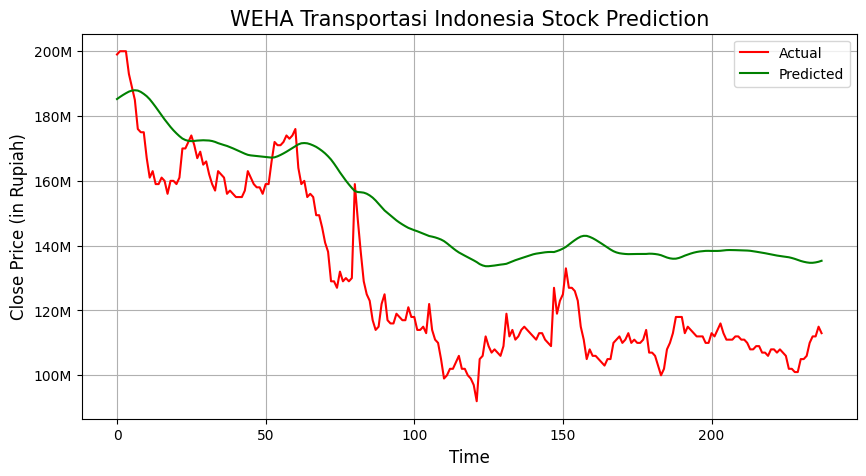

In [52]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('WEHA Transportasi Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/weha_relu_sgd.h5')

##### ReLU - Adamax

In [53]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 26s 777ms/step - loss: 0.0337 - val_loss: 0.0088
Epoch 2/10
24/24 [==============================] - 15s 628ms/step - loss: 0.0050 - val_loss: 0.0081
Epoch 3/10
24/24 [==============================] - 16s 653ms/step - loss: 0.0035 - val_loss: 0.0075
Epoch 4/10
24/24 [==============================] - 17s 702ms/step - loss: 0.0029 - val_loss: 0.0074
Epoch 5/10
24/24 [==============================] - 17s 722ms/step - loss: 0.0027 - val_loss: 0.0069
Epoch 6/10
24/24 [==============================] - 17s 685ms/step - loss: 0.0025 - val_loss: 0.0071
Epoch 7/10
24/24 [==============================] - 19s 774ms/step - loss: 0.0024 - val_loss: 0.0070
Epoch 8/10
24/24 [==============================] - 16s 679ms/step - loss: 0.0024 - val_loss: 0.0074
Epoch 9/10
24/24 [==============================] - 15s 617ms/step - loss: 0.0021 - val_loss: 0.0070
Epoch 10/10
24/24 [==============================] - 14s 597ms/step - loss: 0.0023 - val_lo

In [54]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 44ms/step
Mean Absolute Percentage Error (MAPE):  0.08702
Mean Absolute Error (MAE):  0.026808
Mean Squared Error (MSE):  0.0011863
Root Mean Squared Error (RMSE):  0.03444
R-Squared:  0.887421


8/8 [==============================] - 0s 48ms/step


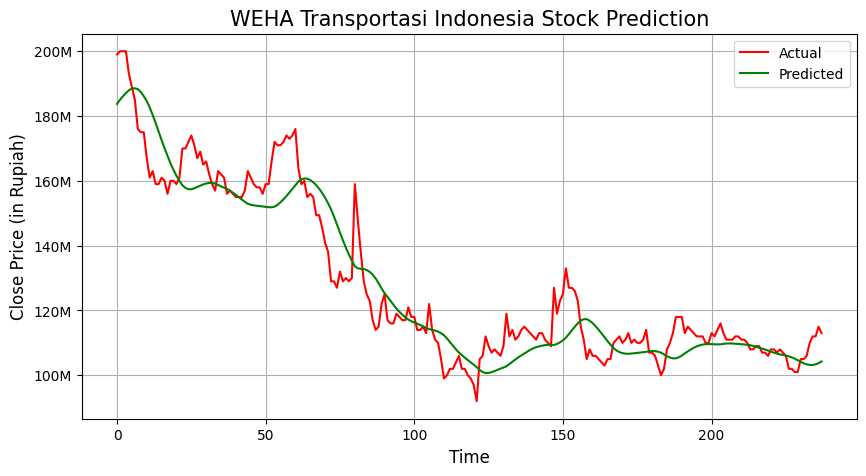

In [55]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('WEHA Transportasi Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/weha_relu_adamax.h5')

##### Sigmoid - Adam

In [56]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 24s 670ms/step - loss: 0.0724 - val_loss: 0.0926
Epoch 2/10
24/24 [==============================] - 15s 647ms/step - loss: 0.0195 - val_loss: 0.0288
Epoch 3/10
24/24 [==============================] - 17s 695ms/step - loss: 0.0062 - val_loss: 0.0124
Epoch 4/10
24/24 [==============================] - 17s 697ms/step - loss: 0.0034 - val_loss: 0.0104
Epoch 5/10
24/24 [==============================] - 15s 613ms/step - loss: 0.0026 - val_loss: 0.0109
Epoch 6/10
24/24 [==============================] - 15s 632ms/step - loss: 0.0022 - val_loss: 0.0097
Epoch 7/10
24/24 [==============================] - 15s 610ms/step - loss: 0.0022 - val_loss: 0.0079
Epoch 8/10
24/24 [==============================] - 15s 615ms/step - loss: 0.0020 - val_loss: 0.0088
Epoch 9/10
24/24 [==============================] - 15s 623ms/step - loss: 0.0017 - val_loss: 0.0090
Epoch 10/10
24/24 [==============================] - 14s 604ms/step - loss: 0.0019 - val_lo

In [57]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 50ms/step
Mean Absolute Percentage Error (MAPE):  0.10666
Mean Absolute Error (MAE):  0.0326048
Mean Squared Error (MSE):  0.0019381
Root Mean Squared Error (RMSE):  0.04402
R-Squared:  0.816077


8/8 [==============================] - 0s 50ms/step


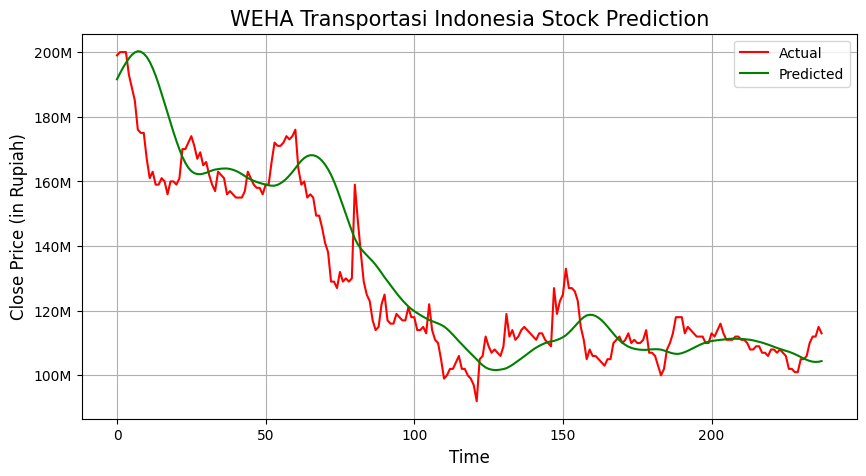

In [58]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('WEHA Transportasi Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/weha_sigmoid_adam.h5')

##### Sigmoid - AdaGrad

In [59]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adagrad')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 23s 676ms/step - loss: 0.5539 - val_loss: 0.2975
Epoch 2/10
24/24 [==============================] - 16s 676ms/step - loss: 0.3967 - val_loss: 0.2224
Epoch 3/10
24/24 [==============================] - 15s 624ms/step - loss: 0.3100 - val_loss: 0.1750
Epoch 4/10
24/24 [==============================] - 15s 615ms/step - loss: 0.2500 - val_loss: 0.1418
Epoch 5/10
24/24 [==============================] - 15s 619ms/step - loss: 0.2046 - val_loss: 0.1174
Epoch 6/10
24/24 [==============================] - 16s 667ms/step - loss: 0.1682 - val_loss: 0.0992
Epoch 7/10
24/24 [==============================] - 15s 624ms/step - loss: 0.1405 - val_loss: 0.0855
Epoch 8/10
24/24 [==============================] - 16s 677ms/step - loss: 0.1172 - val_loss: 0.0752
Epoch 9/10
24/24 [==============================] - 15s 625ms/step - loss: 0.0988 - val_loss: 0.0676
Epoch 10/10
24/24 [==============================] - 15s 640ms/step - loss: 0.0842 - val_lo

In [60]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 54ms/step
Mean Absolute Percentage Error (MAPE):  0.17822
Mean Absolute Error (MAE):  0.0689379
Mean Squared Error (MSE):  0.0108396
Root Mean Squared Error (RMSE):  0.10411
R-Squared:  -0.028668


8/8 [==============================] - 0s 50ms/step


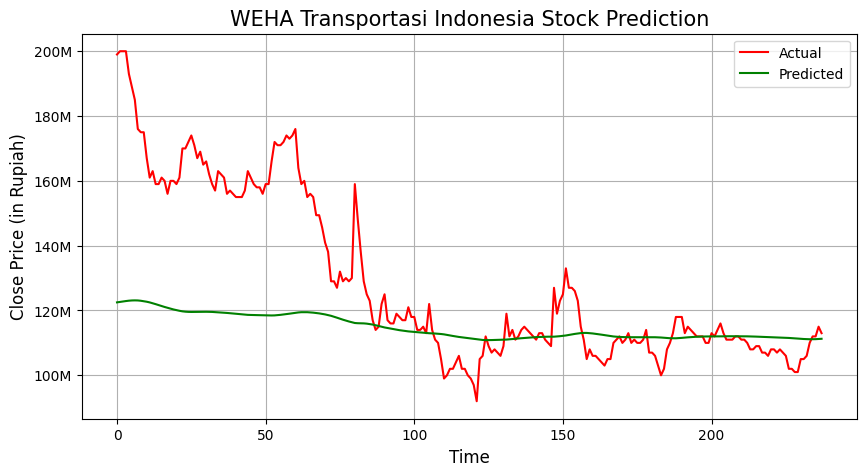

In [61]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('WEHA Transportasi Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/weha_sigmoid_adagrad.h5')

##### Sigmoid - Nadam

In [62]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 24s 645ms/step - loss: 0.0811 - val_loss: 0.0100
Epoch 2/10
24/24 [==============================] - 14s 587ms/step - loss: 0.0033 - val_loss: 0.0088
Epoch 3/10
24/24 [==============================] - 14s 591ms/step - loss: 0.0026 - val_loss: 0.0084
Epoch 4/10
24/24 [==============================] - 15s 637ms/step - loss: 0.0024 - val_loss: 0.0076
Epoch 5/10
24/24 [==============================] - 15s 604ms/step - loss: 0.0022 - val_loss: 0.0072
Epoch 6/10
24/24 [==============================] - 14s 596ms/step - loss: 0.0020 - val_loss: 0.0072
Epoch 7/10
24/24 [==============================] - 14s 600ms/step - loss: 0.0019 - val_loss: 0.0069
Epoch 8/10
24/24 [==============================] - 15s 632ms/step - loss: 0.0018 - val_loss: 0.0070
Epoch 9/10
24/24 [==============================] - 14s 603ms/step - loss: 0.0018 - val_loss: 0.0066
Epoch 10/10
24/24 [==============================] - 15s 606ms/step - loss: 0.0017 - val_lo

In [63]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 44ms/step
Mean Absolute Percentage Error (MAPE):  0.10249
Mean Absolute Error (MAE):  0.0317559
Mean Squared Error (MSE):  0.0018798
Root Mean Squared Error (RMSE):  0.04336
R-Squared:  0.821611


8/8 [==============================] - 0s 48ms/step


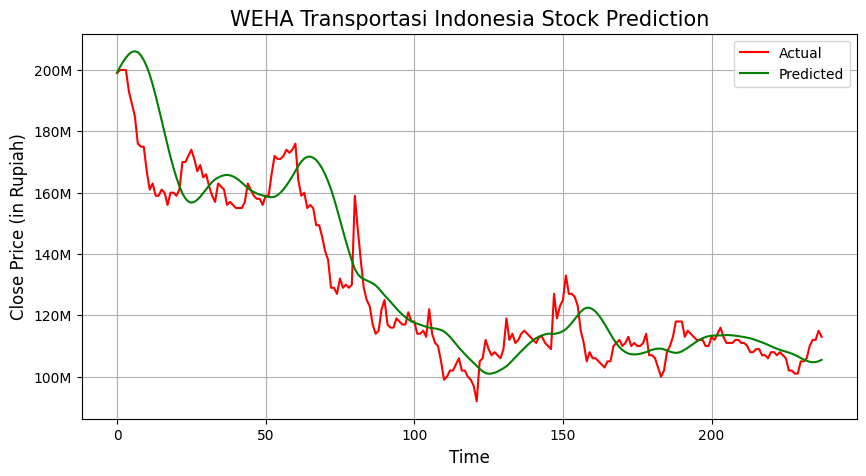

In [64]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('WEHA Transportasi Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/weha_sigmoid_nadam.h5')

##### Sigmoid - RMSProp

In [65]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 20s 538ms/step - loss: 0.1487 - val_loss: 0.0478
Epoch 2/10
24/24 [==============================] - 10s 434ms/step - loss: 0.0269 - val_loss: 0.0225
Epoch 3/10
24/24 [==============================] - 10s 408ms/step - loss: 0.0170 - val_loss: 0.0466
Epoch 4/10
24/24 [==============================] - 10s 408ms/step - loss: 0.0203 - val_loss: 0.0222
Epoch 5/10
24/24 [==============================] - 11s 468ms/step - loss: 0.0135 - val_loss: 0.0139
Epoch 6/10
24/24 [==============================] - 11s 463ms/step - loss: 0.0118 - val_loss: 0.0117
Epoch 7/10
24/24 [==============================] - 11s 453ms/step - loss: 0.0109 - val_loss: 0.0061
Epoch 8/10
24/24 [==============================] - 11s 461ms/step - loss: 0.0089 - val_loss: 0.0059
Epoch 9/10
24/24 [==============================] - 11s 471ms/step - loss: 0.0089 - val_loss: 0.0061
Epoch 10/10
24/24 [==============================] - 13s 563ms/step - loss: 0.0068 - val_lo

In [66]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 3s 59ms/step
Mean Absolute Percentage Error (MAPE):  0.21551
Mean Absolute Error (MAE):  0.063835
Mean Squared Error (MSE):  0.0050953
Root Mean Squared Error (RMSE):  0.07138
R-Squared:  0.516456


8/8 [==============================] - 1s 68ms/step


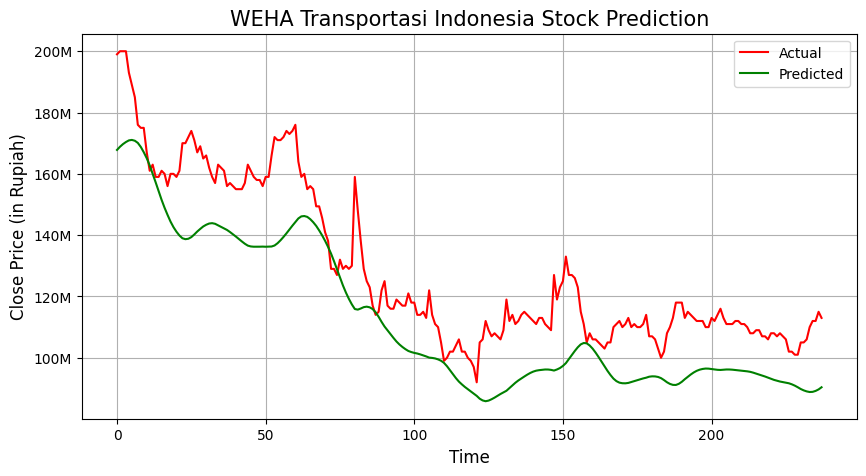

In [67]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('WEHA Transportasi Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/weha_sigmoid_rmsprop.h5')

##### Sigmoid - AdaDelta

In [68]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 20s 516ms/step - loss: 0.2650 - val_loss: 0.1665
Epoch 2/10
24/24 [==============================] - 11s 470ms/step - loss: 0.2635 - val_loss: 0.1656
Epoch 3/10
24/24 [==============================] - 11s 466ms/step - loss: 0.2617 - val_loss: 0.1647
Epoch 4/10
24/24 [==============================] - 11s 446ms/step - loss: 0.2605 - val_loss: 0.1637
Epoch 5/10
24/24 [==============================] - 11s 459ms/step - loss: 0.2590 - val_loss: 0.1628
Epoch 6/10
24/24 [==============================] - 11s 456ms/step - loss: 0.2576 - val_loss: 0.1618
Epoch 7/10
24/24 [==============================] - 11s 455ms/step - loss: 0.2562 - val_loss: 0.1609
Epoch 8/10
24/24 [==============================] - 12s 491ms/step - loss: 0.2544 - val_loss: 0.1599
Epoch 9/10
24/24 [==============================] - 13s 559ms/step - loss: 0.2526 - val_loss: 0.1589
Epoch 10/10
24/24 [==============================] - 13s 525ms/step - loss: 0.2510 - val_lo

In [69]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 49ms/step
Mean Absolute Percentage Error (MAPE):  0.91764
Mean Absolute Error (MAE):  0.2844228
Mean Squared Error (MSE):  0.0908752
Root Mean Squared Error (RMSE):  0.30146
R-Squared:  -7.623981


8/8 [==============================] - 0s 42ms/step


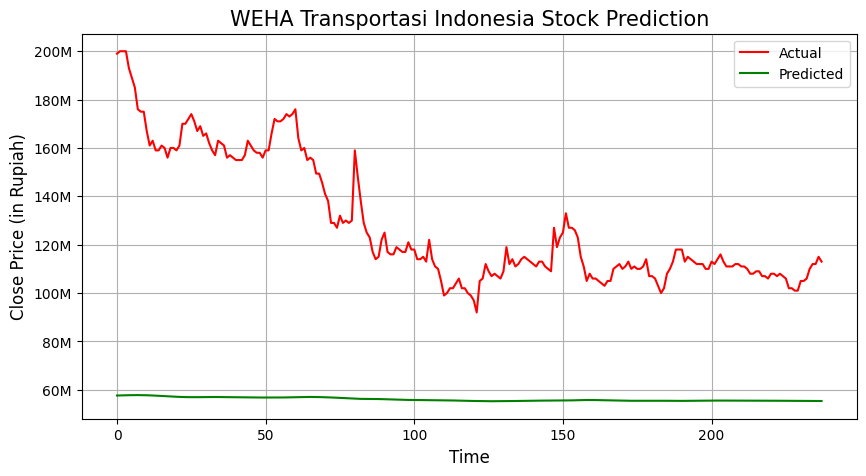

In [70]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('WEHA Transportasi Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/weha_sigmoid_adadelta.h5')

##### Sigmoid - SGD

In [71]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 22s 635ms/step - loss: 0.0427 - val_loss: 0.1066
Epoch 2/10
24/24 [==============================] - 15s 611ms/step - loss: 0.0418 - val_loss: 0.1033
Epoch 3/10
24/24 [==============================] - 14s 598ms/step - loss: 0.0412 - val_loss: 0.1031
Epoch 4/10
24/24 [==============================] - 15s 645ms/step - loss: 0.0409 - val_loss: 0.1046
Epoch 5/10
24/24 [==============================] - 14s 601ms/step - loss: 0.0403 - val_loss: 0.1042
Epoch 6/10
24/24 [==============================] - 15s 616ms/step - loss: 0.0401 - val_loss: 0.0987
Epoch 7/10
24/24 [==============================] - 16s 660ms/step - loss: 0.0394 - val_loss: 0.1006
Epoch 8/10
24/24 [==============================] - 13s 562ms/step - loss: 0.0392 - val_loss: 0.1019
Epoch 9/10
24/24 [==============================] - 14s 567ms/step - loss: 0.0387 - val_loss: 0.1022
Epoch 10/10
24/24 [==============================] - 13s 556ms/step - loss: 0.0382 - val_lo

In [72]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 49ms/step
Mean Absolute Percentage Error (MAPE):  0.6998
Mean Absolute Error (MAE):  0.1725026
Mean Squared Error (MSE):  0.0376212
Root Mean Squared Error (RMSE):  0.19396
R-Squared:  -2.570219


8/8 [==============================] - 0s 46ms/step


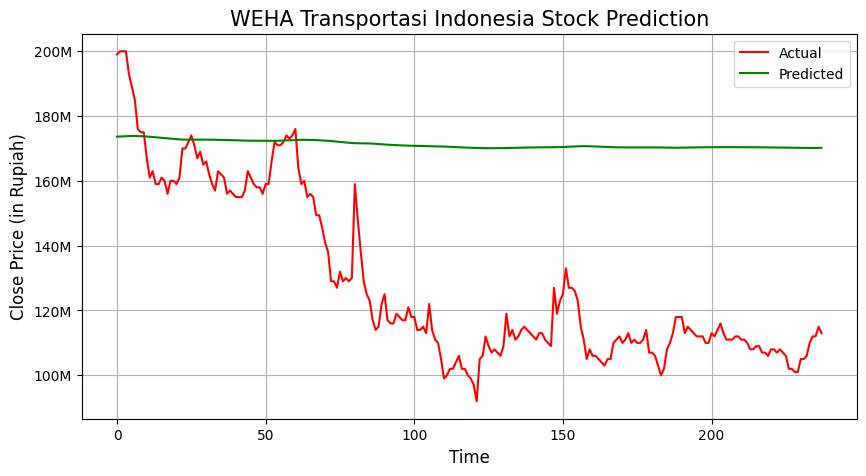

In [73]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('WEHA Transportasi Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/weha_sigmoid_sgd.h5')

##### Sigmoid - Adamax

In [74]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 20s 501ms/step - loss: 0.0494 - val_loss: 0.0255
Epoch 2/10
24/24 [==============================] - 11s 446ms/step - loss: 0.0103 - val_loss: 0.0166
Epoch 3/10
24/24 [==============================] - 11s 475ms/step - loss: 0.0045 - val_loss: 0.0110
Epoch 4/10
24/24 [==============================] - 12s 515ms/step - loss: 0.0029 - val_loss: 0.0099
Epoch 5/10
24/24 [==============================] - 13s 551ms/step - loss: 0.0025 - val_loss: 0.0093
Epoch 6/10
24/24 [==============================] - 13s 551ms/step - loss: 0.0026 - val_loss: 0.0089
Epoch 7/10
24/24 [==============================] - 12s 510ms/step - loss: 0.0023 - val_loss: 0.0085
Epoch 8/10
24/24 [==============================] - 11s 478ms/step - loss: 0.0022 - val_loss: 0.0082
Epoch 9/10
24/24 [==============================] - 12s 487ms/step - loss: 0.0021 - val_loss: 0.0079
Epoch 10/10
24/24 [==============================] - 12s 489ms/step - loss: 0.0019 - val_lo

In [75]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 39ms/step
Mean Absolute Percentage Error (MAPE):  0.104
Mean Absolute Error (MAE):  0.0313597
Mean Squared Error (MSE):  0.0017734
Root Mean Squared Error (RMSE):  0.04211
R-Squared:  0.831706


8/8 [==============================] - 0s 43ms/step


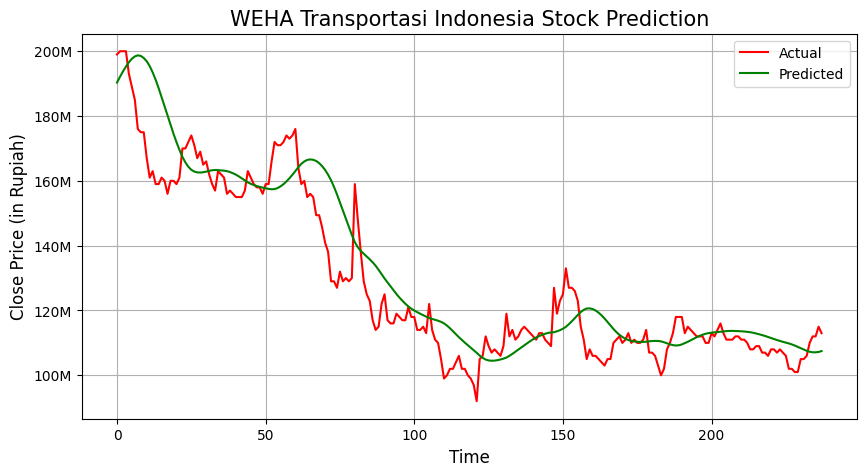

In [76]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('WEHA Transportasi Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/weha_sigmoid_adamax.h5')

##### Tanh - Adam

In [77]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 21s 559ms/step - loss: 0.0296 - val_loss: 0.0082
Epoch 2/10
24/24 [==============================] - 12s 494ms/step - loss: 0.0045 - val_loss: 0.0056
Epoch 3/10
24/24 [==============================] - 12s 512ms/step - loss: 0.0027 - val_loss: 0.0052
Epoch 4/10
24/24 [==============================] - 12s 491ms/step - loss: 0.0023 - val_loss: 0.0051
Epoch 5/10
24/24 [==============================] - 12s 518ms/step - loss: 0.0020 - val_loss: 0.0052
Epoch 6/10
24/24 [==============================] - 12s 515ms/step - loss: 0.0018 - val_loss: 0.0049
Epoch 7/10
24/24 [==============================] - 12s 499ms/step - loss: 0.0018 - val_loss: 0.0048
Epoch 8/10
24/24 [==============================] - 12s 494ms/step - loss: 0.0016 - val_loss: 0.0047
Epoch 9/10
24/24 [==============================] - 12s 507ms/step - loss: 0.0017 - val_loss: 0.0048
Epoch 10/10
24/24 [==============================] - 12s 512ms/step - loss: 0.0015 - val_lo

In [78]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 43ms/step
Mean Absolute Percentage Error (MAPE):  0.07891
Mean Absolute Error (MAE):  0.0240169
Mean Squared Error (MSE):  0.0010217
Root Mean Squared Error (RMSE):  0.03196
R-Squared:  0.903038


8/8 [==============================] - 0s 41ms/step


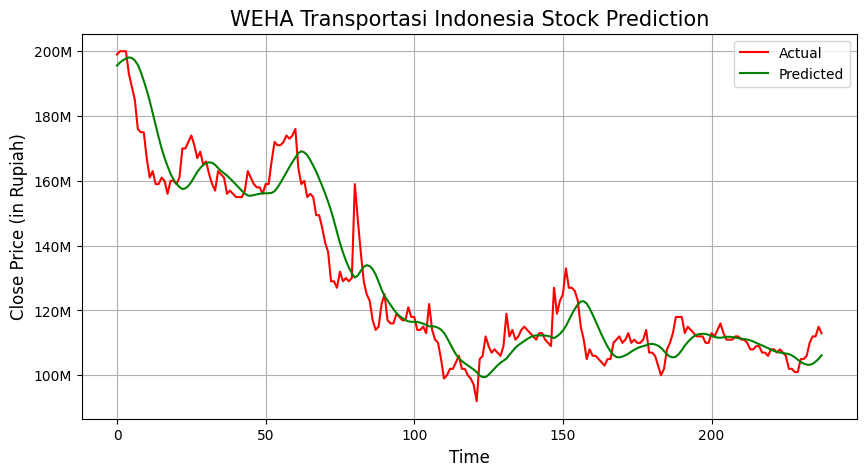

In [79]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('WEHA Transportasi Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/weha_tanh_adam.h5')

##### Tanh - AdaGrad

In [80]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adagrad')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 17s 453ms/step - loss: 0.1657 - val_loss: 0.0690
Epoch 2/10
24/24 [==============================] - 8s 324ms/step - loss: 0.0694 - val_loss: 0.0474
Epoch 3/10
24/24 [==============================] - 8s 335ms/step - loss: 0.0377 - val_loss: 0.0432
Epoch 4/10
24/24 [==============================] - 8s 350ms/step - loss: 0.0267 - val_loss: 0.0433
Epoch 5/10
24/24 [==============================] - 8s 331ms/step - loss: 0.0227 - val_loss: 0.0436
Epoch 6/10
24/24 [==============================] - 8s 342ms/step - loss: 0.0215 - val_loss: 0.0433
Epoch 7/10
24/24 [==============================] - 8s 350ms/step - loss: 0.0203 - val_loss: 0.0423
Epoch 8/10
24/24 [==============================] - 8s 339ms/step - loss: 0.0190 - val_loss: 0.0412
Epoch 9/10
24/24 [==============================] - 8s 347ms/step - loss: 0.0193 - val_loss: 0.0398
Epoch 10/10
24/24 [==============================] - 8s 350ms/step - loss: 0.0181 - val_loss: 0.038

In [81]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 3s 46ms/step
Mean Absolute Percentage Error (MAPE):  0.48608
Mean Absolute Error (MAE):  0.1218095
Mean Squared Error (MSE):  0.0179287
Root Mean Squared Error (RMSE):  0.1339
R-Squared:  -0.701417


8/8 [==============================] - 0s 40ms/step


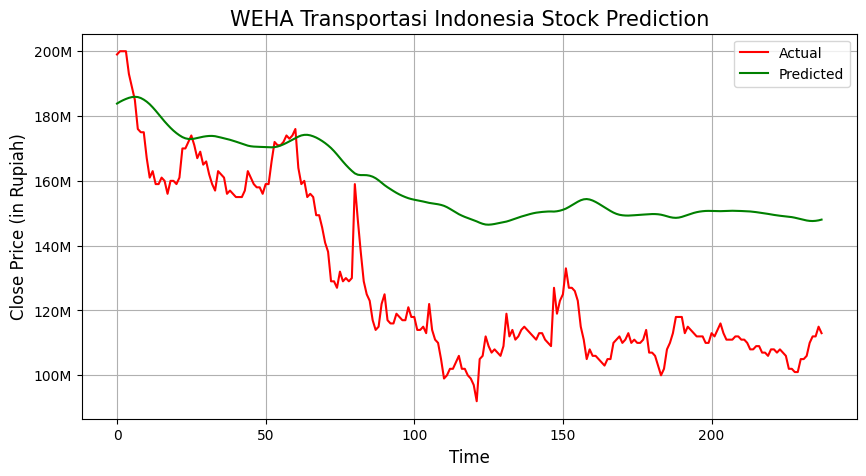

In [82]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('WEHA Transportasi Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/weha_tanh_adagrad.h5')

##### Tanh - Nadam

In [83]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 20s 445ms/step - loss: 0.0309 - val_loss: 0.0069
Epoch 2/10
24/24 [==============================] - 10s 410ms/step - loss: 0.0031 - val_loss: 0.0062
Epoch 3/10
24/24 [==============================] - 9s 371ms/step - loss: 0.0025 - val_loss: 0.0059
Epoch 4/10
24/24 [==============================] - 9s 366ms/step - loss: 0.0022 - val_loss: 0.0060
Epoch 5/10
24/24 [==============================] - 9s 363ms/step - loss: 0.0020 - val_loss: 0.0055
Epoch 6/10
24/24 [==============================] - 9s 361ms/step - loss: 0.0021 - val_loss: 0.0055
Epoch 7/10
24/24 [==============================] - 10s 403ms/step - loss: 0.0018 - val_loss: 0.0055
Epoch 8/10
24/24 [==============================] - 9s 388ms/step - loss: 0.0019 - val_loss: 0.0052
Epoch 9/10
24/24 [==============================] - 9s 377ms/step - loss: 0.0017 - val_loss: 0.0053
Epoch 10/10
24/24 [==============================] - 9s 394ms/step - loss: 0.0017 - val_loss: 0.0

In [84]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 39ms/step
Mean Absolute Percentage Error (MAPE):  0.08549
Mean Absolute Error (MAE):  0.0260559
Mean Squared Error (MSE):  0.0012011
Root Mean Squared Error (RMSE):  0.03466
R-Squared:  0.886013


8/8 [==============================] - 0s 41ms/step


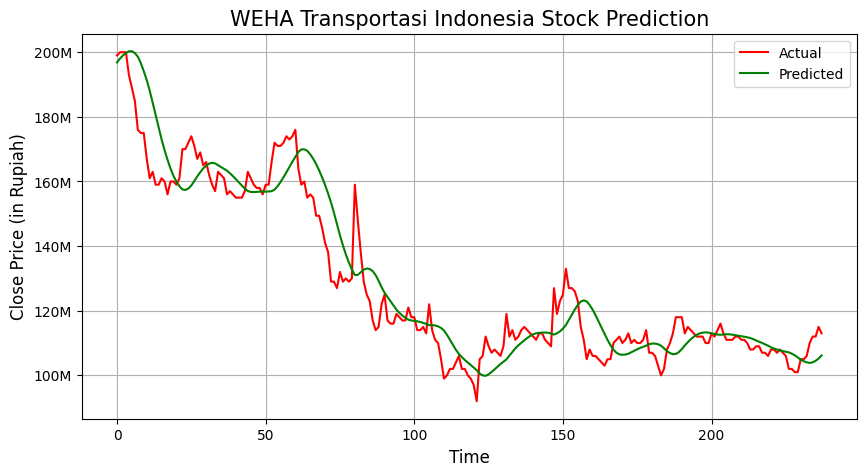

In [85]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('WEHA Transportasi Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/weha_tanh_nadam.h5')

##### Tanh - RMSProp

In [86]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 19s 473ms/step - loss: 0.0262 - val_loss: 0.0077
Epoch 2/10
24/24 [==============================] - 10s 424ms/step - loss: 0.0086 - val_loss: 0.0063
Epoch 3/10
24/24 [==============================] - 11s 449ms/step - loss: 0.0070 - val_loss: 0.0074
Epoch 4/10
24/24 [==============================] - 10s 435ms/step - loss: 0.0063 - val_loss: 0.0063
Epoch 5/10
24/24 [==============================] - 10s 437ms/step - loss: 0.0053 - val_loss: 0.0078
Epoch 6/10
24/24 [==============================] - 11s 479ms/step - loss: 0.0042 - val_loss: 0.0085
Epoch 7/10
24/24 [==============================] - 10s 436ms/step - loss: 0.0044 - val_loss: 0.0071
Epoch 8/10
24/24 [==============================] - 10s 427ms/step - loss: 0.0037 - val_loss: 0.0091
Epoch 9/10
24/24 [==============================] - 10s 414ms/step - loss: 0.0038 - val_loss: 0.0044
Epoch 10/10
24/24 [==============================] - 11s 446ms/step - loss: 0.0029 - val_lo

In [87]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 3s 67ms/step
Mean Absolute Percentage Error (MAPE):  0.16686
Mean Absolute Error (MAE):  0.0497766
Mean Squared Error (MSE):  0.0036253
Root Mean Squared Error (RMSE):  0.06021
R-Squared:  0.655963


8/8 [==============================] - 0s 41ms/step


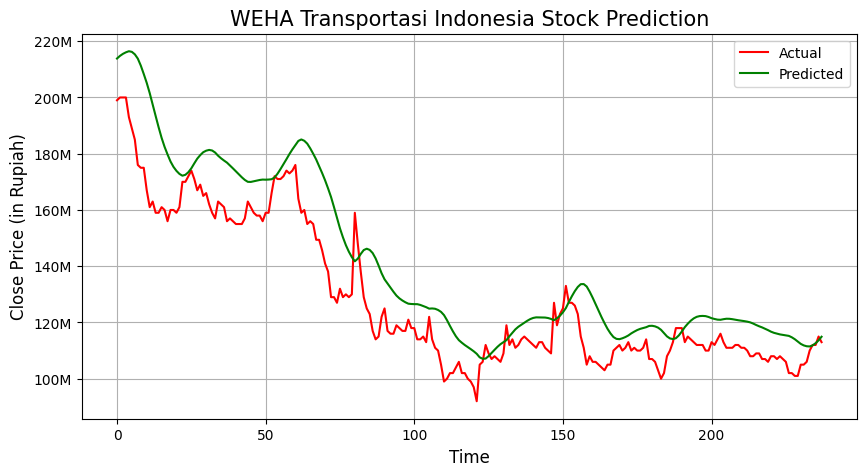

In [88]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('WEHA Transportasi Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/weha_tanh_rmsprop.h5')

##### Tanh - AdaDelta

In [89]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 20s 498ms/step - loss: 0.2469 - val_loss: 0.1550
Epoch 2/10
24/24 [==============================] - 10s 411ms/step - loss: 0.2423 - val_loss: 0.1523
Epoch 3/10
24/24 [==============================] - 10s 418ms/step - loss: 0.2383 - val_loss: 0.1497
Epoch 4/10
24/24 [==============================] - 11s 477ms/step - loss: 0.2336 - val_loss: 0.1470
Epoch 5/10
24/24 [==============================] - 12s 491ms/step - loss: 0.2287 - val_loss: 0.1442
Epoch 6/10
24/24 [==============================] - 11s 469ms/step - loss: 0.2248 - val_loss: 0.1415
Epoch 7/10
24/24 [==============================] - 10s 421ms/step - loss: 0.2200 - val_loss: 0.1388
Epoch 8/10
24/24 [==============================] - 10s 426ms/step - loss: 0.2146 - val_loss: 0.1360
Epoch 9/10
24/24 [==============================] - 11s 464ms/step - loss: 0.2109 - val_loss: 0.1332
Epoch 10/10
24/24 [==============================] - 11s 481ms/step - loss: 0.2067 - val_lo

In [90]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 41ms/step
Mean Absolute Percentage Error (MAPE):  0.82592
Mean Absolute Error (MAE):  0.2558806
Mean Squared Error (MSE):  0.0735077
Root Mean Squared Error (RMSE):  0.27112
R-Squared:  -5.975819


8/8 [==============================] - 0s 50ms/step


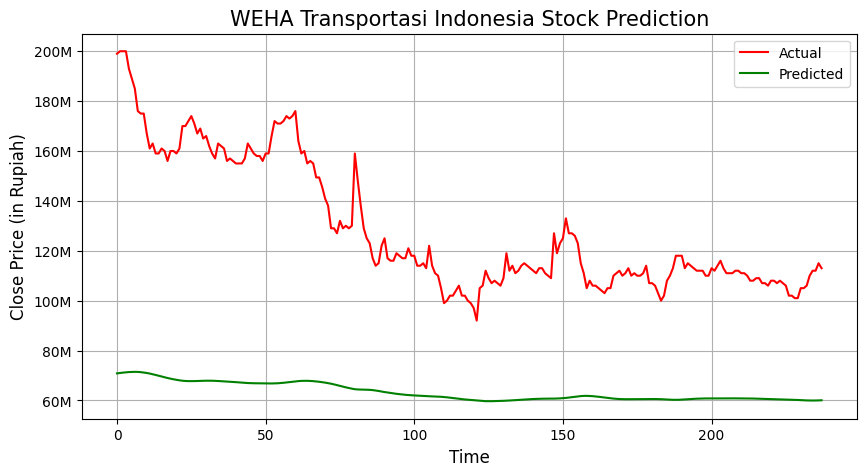

In [91]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('WEHA Transportasi Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/weha_tanh_adadelta.h5')

##### Tanh - SGD

In [92]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 20s 562ms/step - loss: 0.0662 - val_loss: 0.0628
Epoch 2/10
24/24 [==============================] - 9s 392ms/step - loss: 0.0263 - val_loss: 0.0578
Epoch 3/10
24/24 [==============================] - 10s 404ms/step - loss: 0.0229 - val_loss: 0.0485
Epoch 4/10
24/24 [==============================] - 10s 399ms/step - loss: 0.0201 - val_loss: 0.0417
Epoch 5/10
24/24 [==============================] - 10s 425ms/step - loss: 0.0169 - val_loss: 0.0335
Epoch 6/10
24/24 [==============================] - 10s 409ms/step - loss: 0.0147 - val_loss: 0.0275
Epoch 7/10
24/24 [==============================] - 9s 392ms/step - loss: 0.0123 - val_loss: 0.0229
Epoch 8/10
24/24 [==============================] - 9s 395ms/step - loss: 0.0107 - val_loss: 0.0186
Epoch 9/10
24/24 [==============================] - 9s 393ms/step - loss: 0.0086 - val_loss: 0.0148
Epoch 10/10
24/24 [==============================] - 10s 400ms/step - loss: 0.0068 - val_loss: 

In [93]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 37ms/step
Mean Absolute Percentage Error (MAPE):  0.24631
Mean Absolute Error (MAE):  0.0641061
Mean Squared Error (MSE):  0.0050561
Root Mean Squared Error (RMSE):  0.07111
R-Squared:  0.520177


8/8 [==============================] - 0s 39ms/step


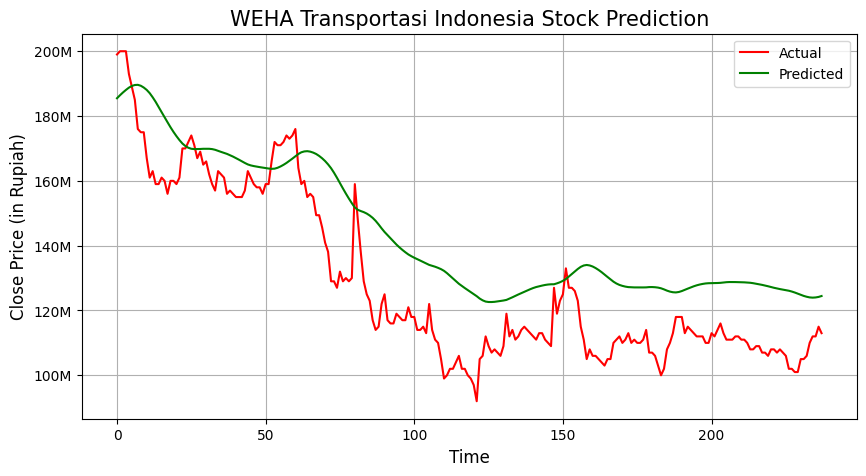

In [94]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('WEHA Transportasi Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/weha_tanh_sgd.h5')

##### Tanh - Adamax

In [95]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 17s 455ms/step - loss: 0.0337 - val_loss: 0.0092
Epoch 2/10
24/24 [==============================] - 9s 384ms/step - loss: 0.0056 - val_loss: 0.0073
Epoch 3/10
24/24 [==============================] - 9s 394ms/step - loss: 0.0039 - val_loss: 0.0064
Epoch 4/10
24/24 [==============================] - 10s 410ms/step - loss: 0.0031 - val_loss: 0.0061
Epoch 5/10
24/24 [==============================] - 9s 391ms/step - loss: 0.0030 - val_loss: 0.0060
Epoch 6/10
24/24 [==============================] - 9s 392ms/step - loss: 0.0027 - val_loss: 0.0059
Epoch 7/10
24/24 [==============================] - 10s 406ms/step - loss: 0.0027 - val_loss: 0.0060
Epoch 8/10
24/24 [==============================] - 10s 402ms/step - loss: 0.0024 - val_loss: 0.0060
Epoch 9/10
24/24 [==============================] - 9s 396ms/step - loss: 0.0023 - val_loss: 0.0059
Epoch 10/10
24/24 [==============================] - 10s 403ms/step - loss: 0.0023 - val_loss: 0

In [96]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 36ms/step
Mean Absolute Percentage Error (MAPE):  0.08601
Mean Absolute Error (MAE):  0.0261473
Mean Squared Error (MSE):  0.0011582
Root Mean Squared Error (RMSE):  0.03403
R-Squared:  0.890084


8/8 [==============================] - 0s 37ms/step


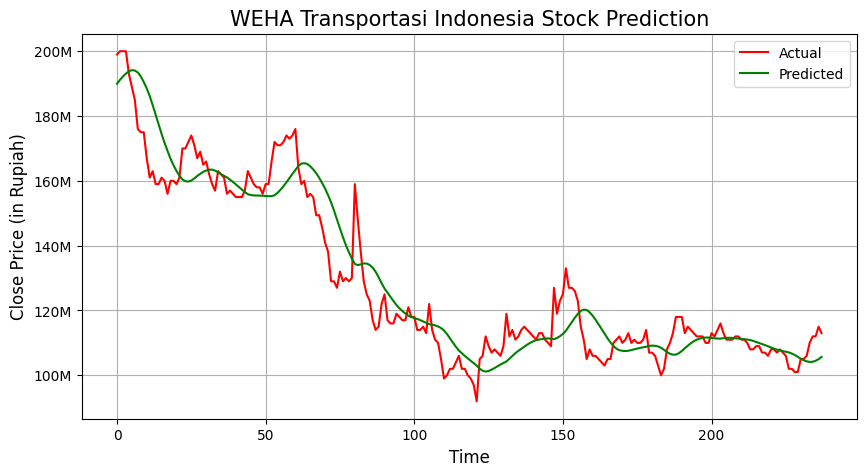

In [97]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('WEHA Transportasi Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/weha_tanh_adamax.h5')

##### Comparison LSTM Model based on Activation and Optimizer Parameter

In [98]:
# Define the activation functions and optimizers to be tested
activations = ['linear', 'relu', 'tanh', 'sigmoid']
optimizers = ['adam', 'adagrad', 'nadam', 'rmsprop', 'adadelta', 'sgd', 'adamax']

# Generate all possible combinations of activation functions and optimizers
combinations = list(itertools.product(activations, optimizers))

# Define a function to build and train an LSTM model with a given activation function and optimizer
def build_model(activations, optimizers):
    model = Sequential()
    model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation=activations))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizers)
    model.fit(X_train, y_train, batch_size=100, epochs=10, validation_split=0.1, verbose=0)
    return model

# Train and evaluate the models for all possible combinations of activation functions and optimizers
results = []
for activations, optimizers in combinations:
    print(f'Training model with {activations} activation and {optimizers} optimizer')
    start_time = time.time()
    model = build_model(activations, optimizers)
    end_time = time.time()
    preds = model.predict(X_test)
    mape = round(metrics.mean_absolute_percentage_error(y_test, preds), 5)
    mae = round(metrics.mean_absolute_error(y_test, preds), 5)
    mse = round(metrics.mean_squared_error(y_test, preds), 5)
    rmse = round(math.sqrt(mse), 5)
    r2 = round(metrics.r2_score(y_test, preds), 2)
    elapsed_time = round(end_time - start_time, 2)
    results.append([activations, optimizers, mape, mae, mse, rmse, r2, elapsed_time])

# Create a DataFrame from the results list
df_result = pd.DataFrame(results, columns=['Activation', 'Optimizer', 'MAPE (%)', 'MAE (%)', 
                                           'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)'])

# Create a pivot table to compare the results
df_pivot_result = pd.pivot_table(df_result, values=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)'], 
                                 index=['Activation', 'Optimizer'])

Training model with linear activation and adam optimizer
8/8 [==============================] - 2s 35ms/step
Training model with linear activation and adagrad optimizer
8/8 [==============================] - 2s 37ms/step
Training model with linear activation and nadam optimizer
8/8 [==============================] - 2s 40ms/step
Training model with linear activation and rmsprop optimizer
8/8 [==============================] - 2s 39ms/step
Training model with linear activation and adadelta optimizer
8/8 [==============================] - 2s 36ms/step
Training model with linear activation and sgd optimizer
8/8 [==============================] - 2s 47ms/step
Training model with linear activation and adamax optimizer
8/8 [==============================] - 2s 45ms/step
Training model with relu activation and adam optimizer
8/8 [==============================] - 2s 47ms/step
Training model with relu activation and adagrad optimizer
8/8 [==============================] - 2s 41ms/step
Training

In [99]:
# Create a DataFrame from the results list
df_result = pd.DataFrame(results, columns=['Activation', 'Optimizer', 'MAPE (%)', 'MAE (%)', 
                                           'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)'])

# Create a pivot table to compare the results
df_pivot_result = pd.pivot_table(df_result, values=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)'], 
                                 index=['Activation', 'Optimizer'])
# Get several LSTM model evaluation 
df_pivot_result.sort_values(by=['Activation', 'Optimizer'], ascending=True)

Elapsed Time (min)  MAE (%)  MAPE (%)  MSE (%)  \
Activation Optimizer                                                   
linear     adadelta               106.00  0.27507   0.88898  0.08470   
           adagrad                 90.04  0.11436   0.45435  0.01567   
           adam                   100.68  0.02617   0.08627  0.00121   
           adamax                 113.55  0.02939   0.09831  0.00146   
           nadam                  101.60  0.03058   0.10123  0.00162   
           rmsprop                103.71  0.02633   0.08440  0.00116   
           sgd                    109.22  0.06869   0.26417  0.00578   
relu       adadelta               110.03  0.28125   0.90941  0.08846   
           adagrad                103.17  0.14099   0.56198  0.02384   
           adam                   104.93  0.02607   0.08507  0.00116   
           adamax                 100.09  0.02820   0.09345  0.00135   
           nadam                  110.48  0.02733   0.08906  0.00129   
           rmsprop                105.87  0.02689   0.08681  0.00119   
           sgd                     99.66  0.11135   0.44292  0.01492   
sigmoid    adadelta               101.78  0.55407   2.07732  0.31837   
           adagrad                105.26  0.08925   0.24410  0.01411   
           adam                   100.10  0.02719   0.08885  0.00128   
           adamax                 105.47  0.04044   0.13865  0.00269   
           nadam                  105.21  0.03187   0.10417  0.00190   
           rmsprop                103.44  0.04589   0.15873  0.00329   
           sgd                     99.80  0.17890   0.72075  0.03944   
tanh       adadelta               103.39  0.27618   0.89118  0.08568   
           adagrad                 99.43  0.11224   0.44393  0.01498   
           adam                    92.69  0.02626   0.08686  0.00122   
           adamax                 111.99  0.02705   0.08875  0.00124   
           nadam                  103.39  0.02626   0.08643  0.00119   
           rmsprop                101.63  0.02417   0.08025  0.00105   
           sgd                    114.21  0.06358   0.24440  0.00497   

                      R-Squared (%)  RMSE (%)  
Activation Optimizer                           
linear     adadelta           -7.04   0.29103  
           adagrad            -0.49   0.12518  
           adam                0.89   0.03479  
           adamax              0.86   0.03821  
           nadam               0.85   0.04025  
           rmsprop             0.89   0.03406  
           sgd                 0.45   0.07603  
relu       adadelta           -7.40   0.29742  
           adagrad            -1.26   0.15440  
           adam                0.89   0.03406  
           adamax              0.87   0.03674  
           nadam               0.88   0.03592  
           rmsprop             0.89   0.03450  
           sgd                -0.42   0.12215  
sigmoid    adadelta          -29.21   0.56424  
           adagrad            -0.34   0.11879  
           adam                0.88   0.03578  
           adamax              0.74   0.05187  
           nadam               0.82   0.04359  
           rmsprop             0.69   0.05736  
           sgd                -2.74   0.19860  
tanh       adadelta           -7.13   0.29271  
           adagrad            -0.42   0.12239  
           adam                0.88   0.03493  
           adamax              0.88   0.03521  
           nadam               0.89   0.03450  
           rmsprop             0.90   0.03240  
           sgd                 0.53   0.07050

In [100]:
# Create a DataFrame from the results list
df_result = pd.DataFrame(results, columns=['Activation', 'Optimizer', 'MAPE (%)', 'MAE (%)', 
                                           'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)'])

# Create a pivot table to compare the results
df_pivot_result = pd.pivot_table(df_result, values=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)'], 
                                 index=['Activation', 'Optimizer'])

# Calculate t-statistics and p-values for each performance metric
for col in ['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)']:
    t_stat, p_val = stats.ttest_1samp(df_result[col], 0.05)
    new_col_name_tstat = '{} (t-Statistic)'.format(col)
    new_col_name_pval = '{} (p-Value)'.format(col)
    df_pivot_result[new_col_name_tstat] = round(t_stat, 5)
    df_pivot_result[new_col_name_pval] = round(p_val, 5)

# Print the resulting pivot table with the horizontal t-statistic and p-value columns
df_pivot_result.sort_values(by=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'Elapsed Time (min)'], ascending=True)

Elapsed Time (min)  MAE (%)  MAPE (%)  MSE (%)  \
Activation Optimizer                                                   
tanh       rmsprop                101.63  0.02417   0.08025  0.00105   
linear     rmsprop                103.71  0.02633   0.08440  0.00116   
relu       adam                   104.93  0.02607   0.08507  0.00116   
linear     adam                   100.68  0.02617   0.08627  0.00121   
tanh       nadam                  103.39  0.02626   0.08643  0.00119   
relu       rmsprop                105.87  0.02689   0.08681  0.00119   
tanh       adam                    92.69  0.02626   0.08686  0.00122   
           adamax                 111.99  0.02705   0.08875  0.00124   
sigmoid    adam                   100.10  0.02719   0.08885  0.00128   
relu       nadam                  110.48  0.02733   0.08906  0.00129   
           adamax                 100.09  0.02820   0.09345  0.00135   
linear     adamax                 113.55  0.02939   0.09831  0.00146   
           nadam                  101.60  0.03058   0.10123  0.00162   
sigmoid    nadam                  105.21  0.03187   0.10417  0.00190   
           adamax                 105.47  0.04044   0.13865  0.00269   
           rmsprop                103.44  0.04589   0.15873  0.00329   
           adagrad                105.26  0.08925   0.24410  0.01411   
tanh       sgd                    114.21  0.06358   0.24440  0.00497   
linear     sgd                    109.22  0.06869   0.26417  0.00578   
relu       sgd                     99.66  0.11135   0.44292  0.01492   
tanh       adagrad                 99.43  0.11224   0.44393  0.01498   
linear     adagrad                 90.04  0.11436   0.45435  0.01567   
relu       adagrad                103.17  0.14099   0.56198  0.02384   
sigmoid    sgd                     99.80  0.17890   0.72075  0.03944   
linear     adadelta               106.00  0.27507   0.88898  0.08470   
tanh       adadelta               103.39  0.27618   0.89118  0.08568   
relu       adadelta               110.03  0.28125   0.90941  0.08846   
sigmoid    adadelta               101.78  0.55407   2.07732  0.31837   

                      R-Squared (%)  RMSE (%)  MAPE (%) (t-Statistic)  \
Activation Optimizer                                                    
tanh       rmsprop             0.90   0.03240                 3.59242   
linear     rmsprop             0.89   0.03406                 3.59242   
relu       adam                0.89   0.03406                 3.59242   
linear     adam                0.89   0.03479                 3.59242   
tanh       nadam               0.89   0.03450                 3.59242   
relu       rmsprop             0.89   0.03450                 3.59242   
tanh       adam                0.88   0.03493                 3.59242   
           adamax              0.88   0.03521                 3.59242   
sigmoid    adam                0.88   0.03578                 3.59242   
relu       nadam               0.88   0.03592                 3.59242   
           adamax              0.87   0.03674                 3.59242   
linear     adamax              0.86   0.03821                 3.59242   
           nadam               0.85   0.04025                 3.59242   
sigmoid    nadam               0.82   0.04359                 3.59242   
           adamax              0.74   0.05187                 3.59242   
           rmsprop             0.69   0.05736                 3.59242   
           adagrad            -0.34   0.11879                 3.59242   
tanh       sgd                 0.53   0.07050                 3.59242   
linear     sgd                 0.45   0.07603                 3.59242   
relu       sgd                -0.42   0.12215                 3.59242   
tanh       adagrad            -0.42   0.12239                 3.59242   
linear     adagrad            -0.49   0.12518                 3.59242   
relu       adagrad            -1.26   0.15440                 3.59242   
sigmoid    sgd                -2.74 

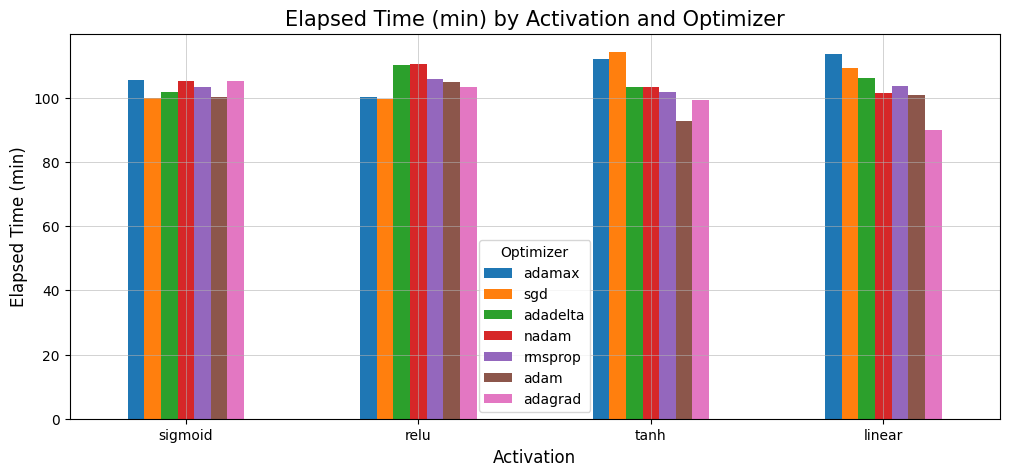

In [101]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_time = df_result.pivot_table(index='Activation', columns='Optimizer', values='Elapsed Time (min)')
# Sort the columns based on the mean elapsed time value
df_time = df_time[df_time.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_time = df_time.sort_index(ascending=True)
# Sort the values in the x-axis in descending order based on the highest mean elapsed time value
df_time = df_time.sort_values(by=df_time.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_time.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Elapsed Time (min)', fontsize=12)
ax.set_title('Elapsed Time (min) by Activation and Optimizer', fontsize=15)
# formatter = ticker.PercentFormatter(xmax=1, decimals=0)
# ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.show()

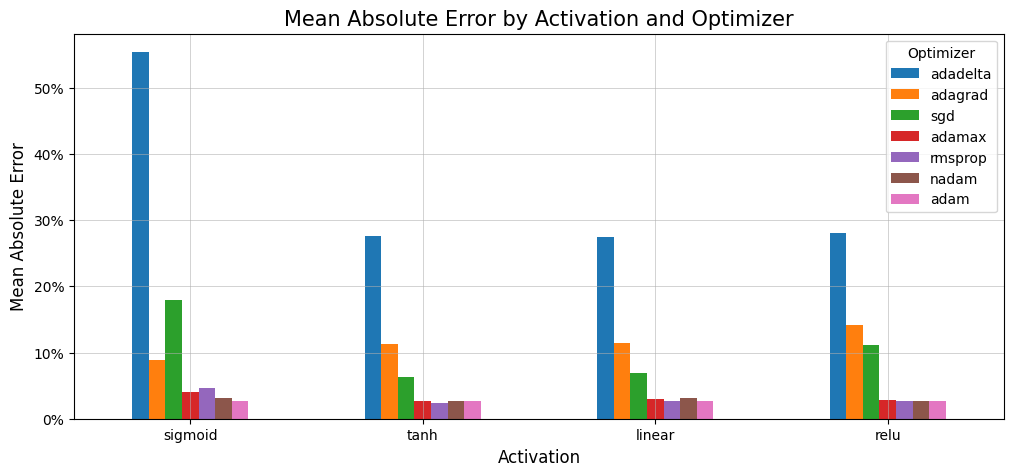

In [102]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_mae = df_result.pivot_table(index='Activation', columns='Optimizer', values='MAE (%)')
# Sort the columns based on the mean MAE value
df_mae = df_mae[df_mae.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_mae = df_mae.sort_index(ascending=True)
# Sort the values in the x-axis in descending order based on the highest mean MAE value
df_mae = df_mae.sort_values(by=df_mae.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_mae.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Mean Absolute Error', fontsize=12)
ax.set_title('Mean Absolute Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

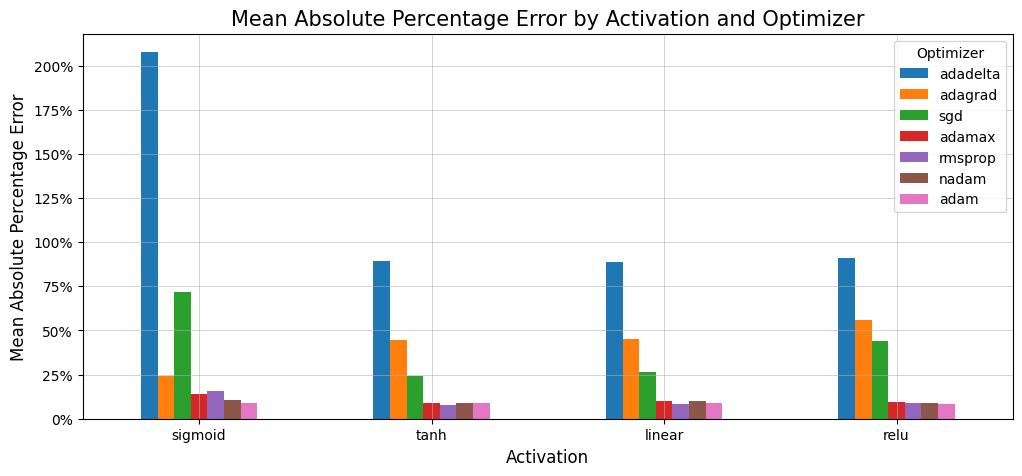

In [103]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_mape = df_result.pivot_table(index='Activation', columns='Optimizer', values='MAPE (%)')
# Sort the columns based on the mean MAPE value
df_mape = df_mape[df_mae.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_mape = df_mape.sort_index(ascending=True)
# Sort the values in the x-axis in descending order based on the highest mean MAPE value
df_mape = df_mape.sort_values(by=df_mape.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_mape.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Mean Absolute Percentage Error', fontsize=12)
ax.set_title('Mean Absolute Percentage Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

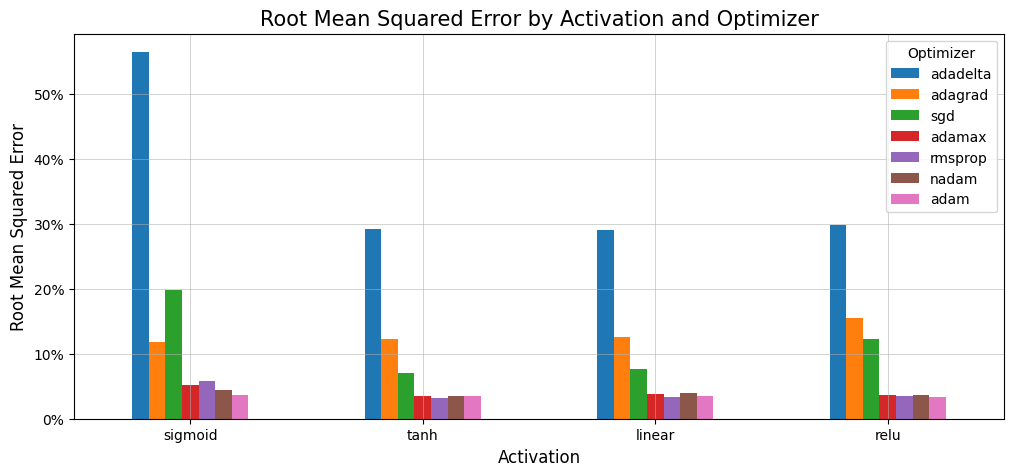

In [104]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_rmse = df_result.pivot_table(index='Activation', columns='Optimizer', values='RMSE (%)')
# Sort the columns based on the mean RMSE value
df_rmse = df_rmse[df_rmse.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_rmse = df_rmse.sort_index(ascending=True)
# Sort the values in the x-axis in descending order based on the highest mean RMSE value
df_rmse = df_rmse.sort_values(by=df_rmse.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_rmse.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Root Mean Squared Error', fontsize=12)
ax.set_title('Root Mean Squared Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

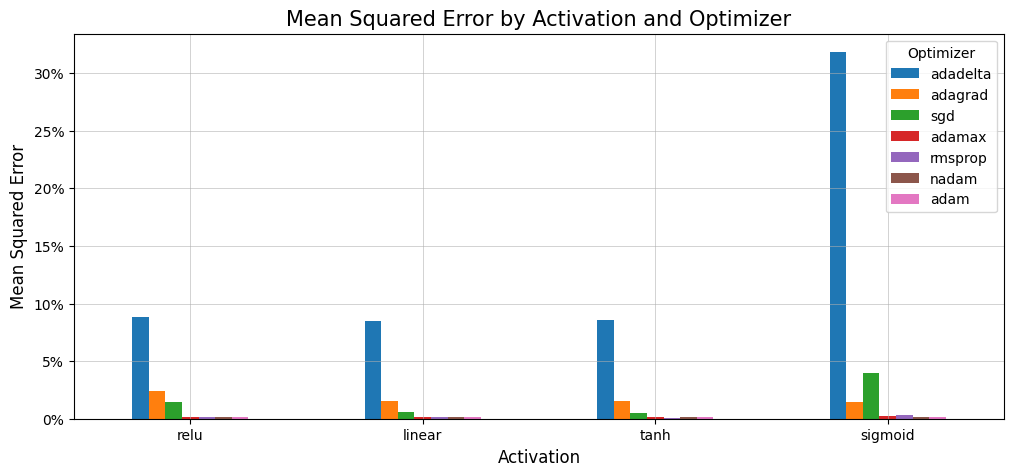

In [105]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_mse = df_result.pivot_table(index='Activation', columns='Optimizer', values='MSE (%)')
# Sort the columns based on the mean RMSE value
df_mse = df_mse[df_mse.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_mse = df_mse.sort_index(ascending=True)
# Sort the values in the x-axis in descending order based on the highest mean RMSE value
df_mse = df_mse.sort_values(by=df_mse.columns[-1], ascending=True)

# Create the stacked bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_mse.plot(kind='bar', ax=ax) # modified line
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Mean Squared Error', fontsize=12) # modified line
ax.set_title('Mean Squared Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.yaxis.set_major_formatter(formatter) # modified line
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0) # modified line
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

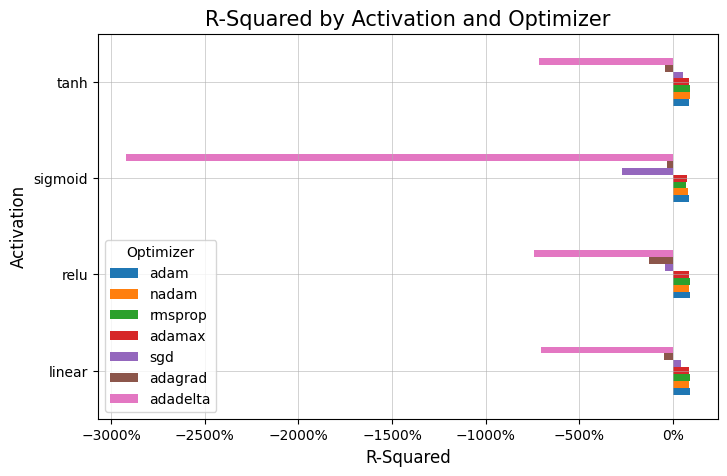

In [106]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_r2 = df_result.pivot_table(index='Activation', columns='Optimizer', values='R-Squared (%)')
# Sort the columns based on the mean RMSE value
df_r2 = df_r2[df_r2.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_r2 = df_r2.sort_index(ascending=True)
# Sort the values in the x-axis in descending order based on the highest mean RMSE value
df_r2 = df_r2.sort_values(by=df_rmse.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(8,5))
df_r2.plot(kind='barh', ax=ax)
ax.set_xlabel('R-Squared', fontsize=12)
ax.set_ylabel('Activation', fontsize=12)
ax.set_title('R-Squared by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.xaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()